## CoT Mid-Year Report

In [1]:
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import scipy.stats as scs

import sklearn as sk
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV,LassoCV
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

import statsmodels as smm
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
from statsmodels.tsa.api import VAR

import pygam
from pygam import LinearGAM
from pygam import s,l,f,te

import warnings
import time
warnings.filterwarnings("ignore")



In [2]:
date_col = ["Timestamp"]
df=pd.read_csv('CMU Data.csv',index_col = "Timestamp")

In [3]:
def plotMissing(df,save=False,title='Missing Values'):
    #Missing value plot
    plt.figure(figsize=(16,12))
    sns.heatmap(df.isnull(),cbar=False)
    #sns.heatmap(df.iloc[np.unique(np.where(df.isnull())[0]),:].isnull(),cbar=False)
    plt.title('Missing Value')
    plt.tight_layout()
    if save:
        plt.savefig(title,dpi=300)
    plt.show()

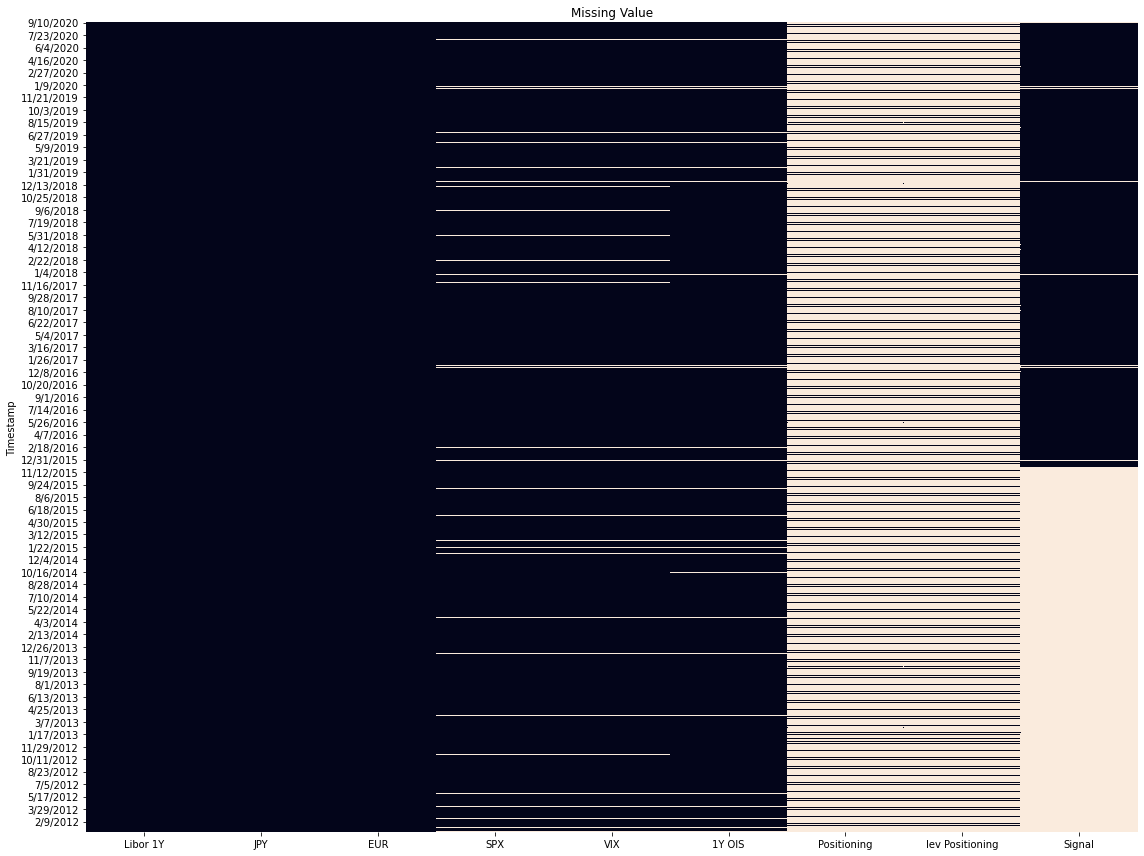

In [4]:
plotMissing(df)

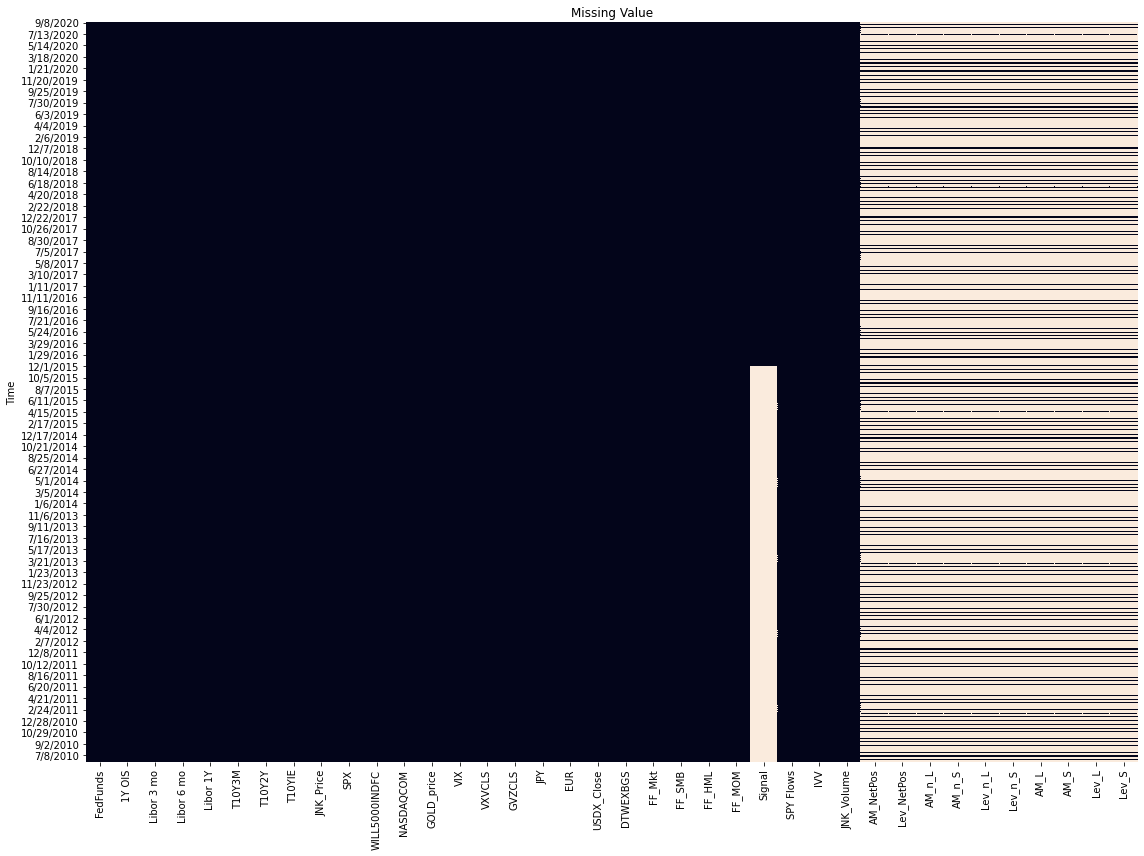

In [5]:
df=pd.read_csv('20201029_ScrubbedDailyRaw.csv',index_col = "Time")
plotMissing(df)

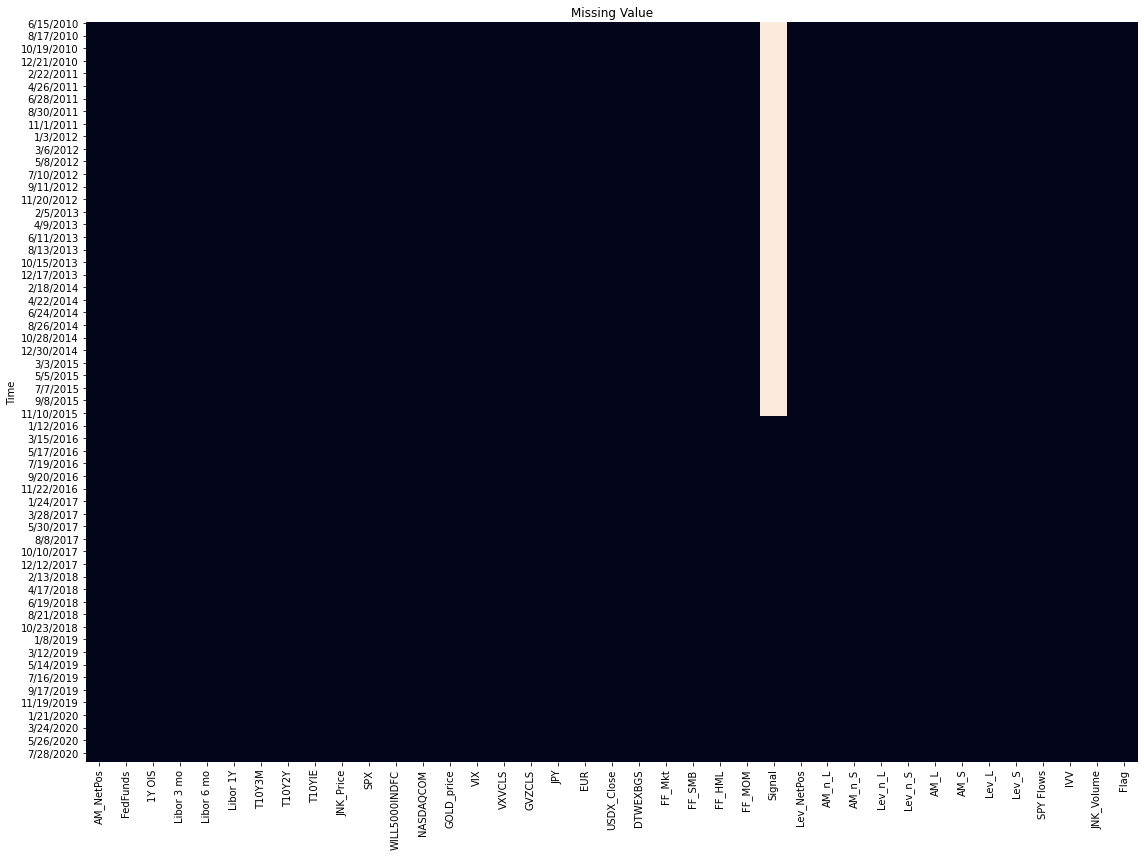

In [6]:
df=pd.read_csv('20201029_ScrubbedWeekly_Returns.csv',index_col = "Time")
plotMissing(df)

In [7]:
train=pd.read_csv('train_weekly.csv',index_col = "Time",parse_dates=True )
test = pd.read_csv('test_weekly.csv',index_col = "Time",parse_dates=True)
cols = ['Unnamed: 0','Signal','Flag']  #cols to drop
train = train.drop(columns = cols)
test = test.drop(columns = cols)
#If we don't want dates as index
#train.Time = pd.to_datetime(train.Time)
#test.Time = pd.to_datetime(test.Time)

In [8]:
#Correlation: Compute the correlation matrix
def plotCorr(labeled,save=False):
    s=10
    corr = labeled.iloc[:,:-1].corr()

    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True

    #sns.set_theme(style="white")
    f, ax = plt.subplots(figsize=(16, 16))
    ax = sns.heatmap(corr, square=True,linewidths=.4,annot=True,annot_kws={"size":8},fmt='.1f',cbar_kws={"shrink": .4}, mask=mask, cmap="coolwarm")
    # Draw the heatmap with the mask and correct aspect ratio
    plt.tight_layout()
    plt.title('Correlation Matrix',size=s)
    if save:
        plt.savefig('Correlation Matrix',dpi=300)
    plt.show()

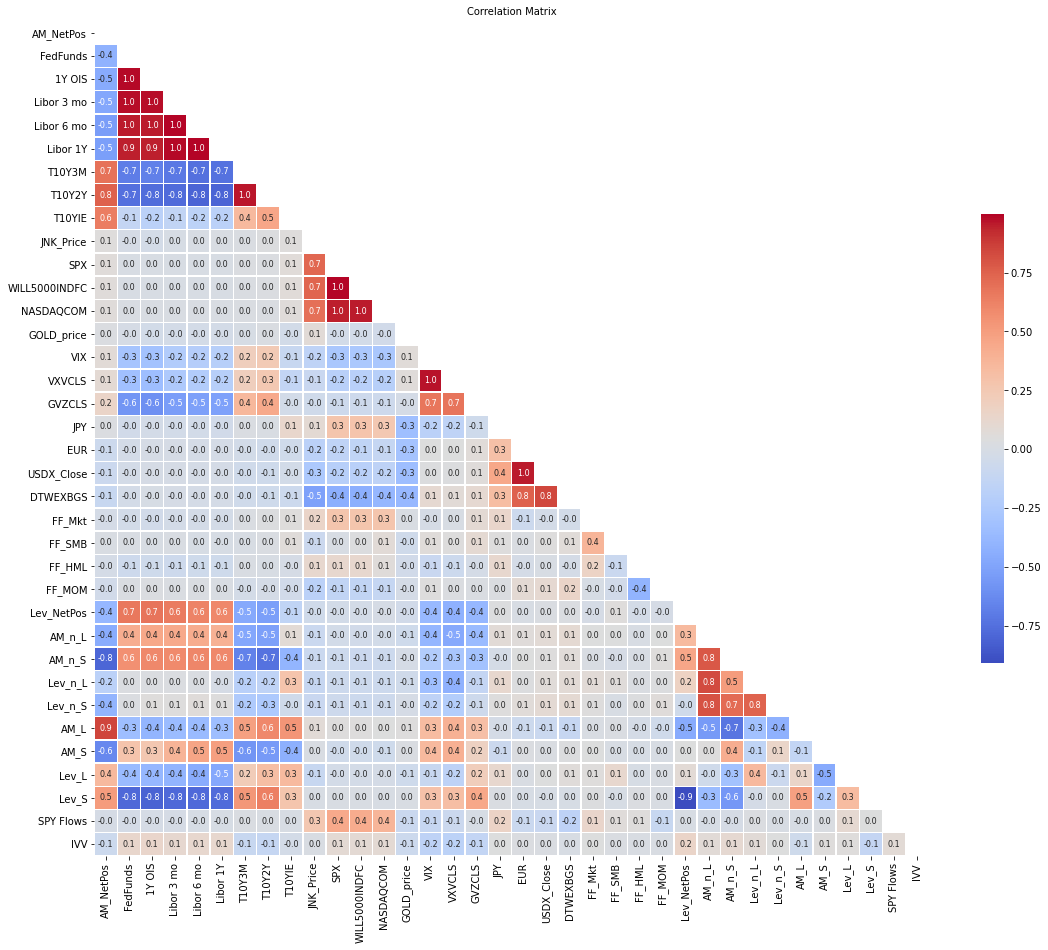

In [9]:
plotCorr(train,save=False)

__Predictor Distributions__

In [10]:
Asset = {'Asset Manager Position':['AM_NetPos','AM_L', 'AM_S'],
         'HF Positions':['Lev_NetPos', 'Lev_L', 'Lev_S'], 
         'Asset Manager Count':['AM_n_L','AM_n_S'],
         'HF Count':['Lev_n_L', 'Lev_n_S'],
         'Int_Rate':['FedFunds', '1Y OIS'],
         'LIBOR':['Libor 3 mo', 'Libor 6 mo','Libor 1Y'],
         'YTM Spread':['T10Y3M','T10Y2Y'],
         'Inflation':['T10YIE'],
         'FX Returns': ['JPY', 'EUR', 'USDX_Close', 'DTWEXBGS'],      
         'Junk_Bond Returns':['JNK_Price'],
         'Equity Returns':['SPX','WILL5000INDFC', 'NASDAQCOM'],
         'Commodity':['GOLD_price'],
         #'Signal':['JNK_Volume','Signal'],
         'Vol':['VIX', 'VXVCLS','GVZCLS'],
         'FamaFrench':['FF_Mkt', 'FF_SMB', 'FF_HML','FF_MOM'],
         'ETF_Flows':['SPY Flows', 'IVV']
        }
key_list = list(Asset.keys())

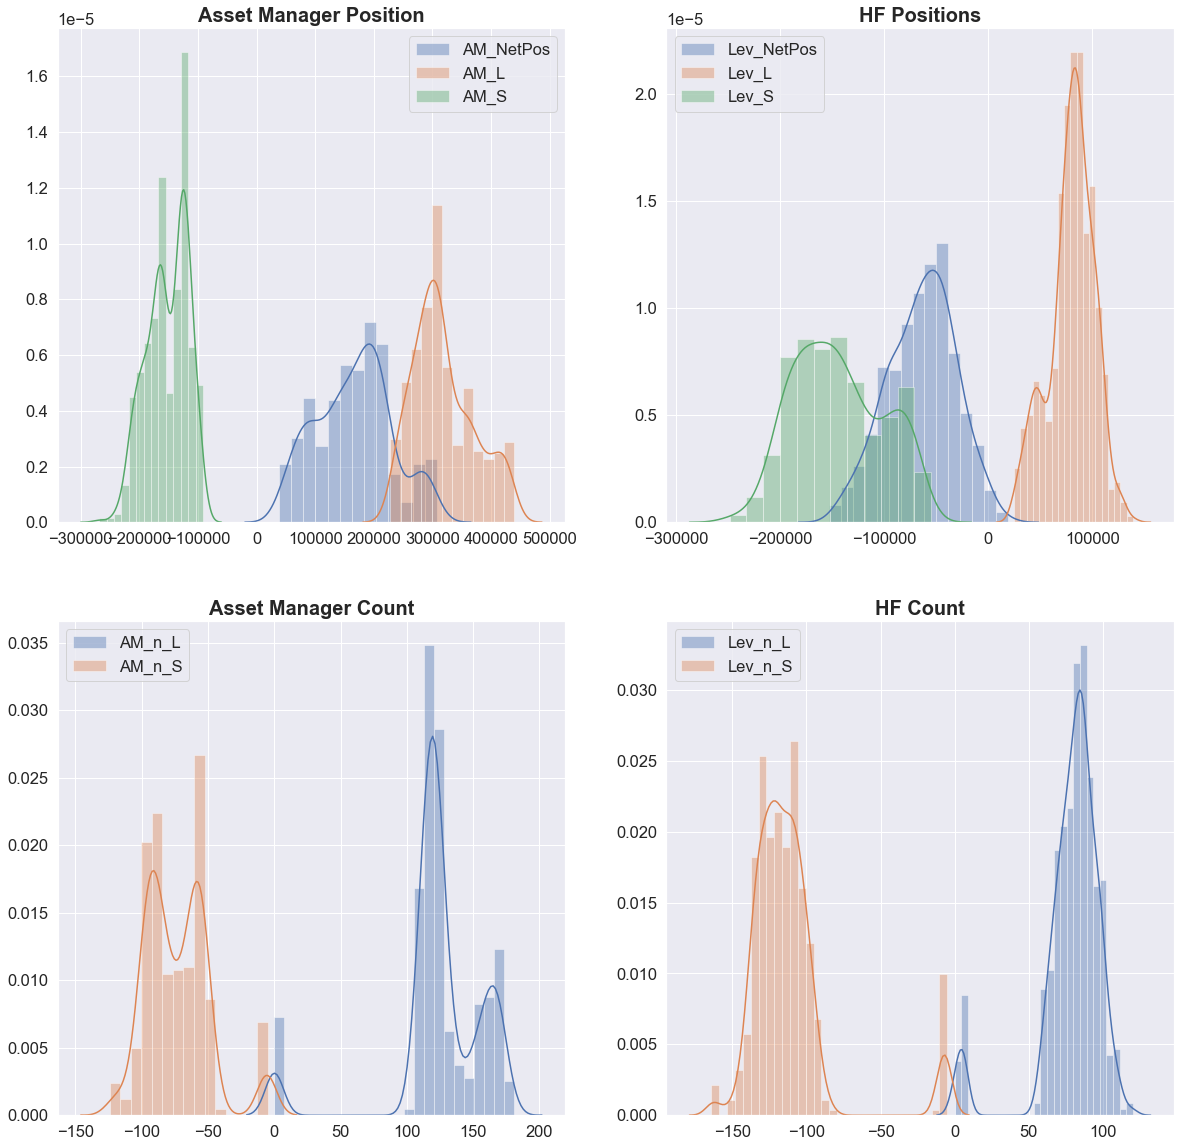

In [11]:
#look at one of each Asset Type Across Time
fig = plt.figure(figsize = (20,20))
sns.set(font_scale = 1.5)
axs = fig.subplots(2,2)
keys_cur = key_list[0:4]
for j in range(len(keys_cur)):    
    item_names = Asset[keys_cur[j]]
    for i in range(len(item_names)):
        axs[j//2, j%2].set_ylabel("Distribution", fontsize = 15)
        axs[j//2, j%2].set_ylabel("", fontsize = 15)
        axs[j//2, j%2].set_title(keys_cur[j], fontsize = 20,fontweight="bold")
        if(item_names[i][-2:]=="_S"):
            x = pd.Series(-df.loc[:,item_names[i]], name = "")
        else:
            x = pd.Series(df.loc[:,item_names[i]], name = "")
        sns.distplot(x, label = item_names[i],ax=axs[j//2,j%2])
    axs[j//2, j%2].legend()

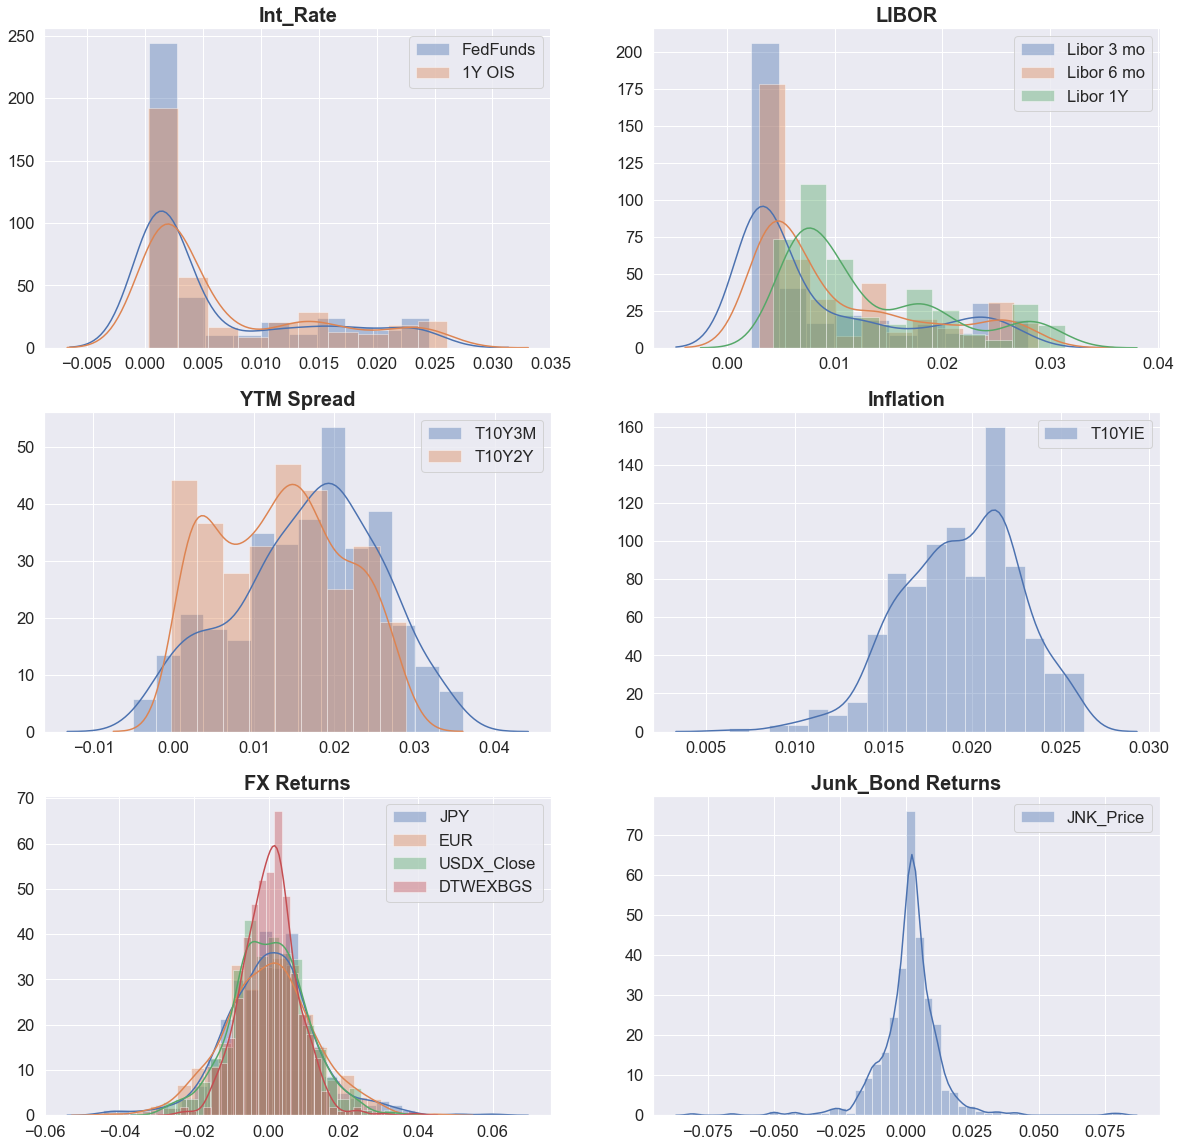

In [12]:
#look at one of each Asset Type Across Time
fig = plt.figure(figsize = (20,20))
sns.set(font_scale = 1.5)
axs = fig.subplots(3,2)
keys_cur = key_list[4:10]
for j in range(len(keys_cur)):    
    item_names = Asset[keys_cur[j]]
    for i in range(len(item_names)):
        axs[j//2, j%2].set_ylabel("Distribution", fontsize = 15)
        axs[j//2, j%2].set_ylabel("", fontsize = 15)
        axs[j//2, j%2].set_title(keys_cur[j], fontsize = 20,fontweight="bold")
        if(item_names[i][-2:]=="_S"):
            x = pd.Series(-df.loc[:,item_names[i]], name = "")
        else:
            x = pd.Series(df.loc[:,item_names[i]], name = "")
        sns.distplot(x, label = item_names[i],ax=axs[j//2,j%2])
    axs[j//2, j%2].legend()

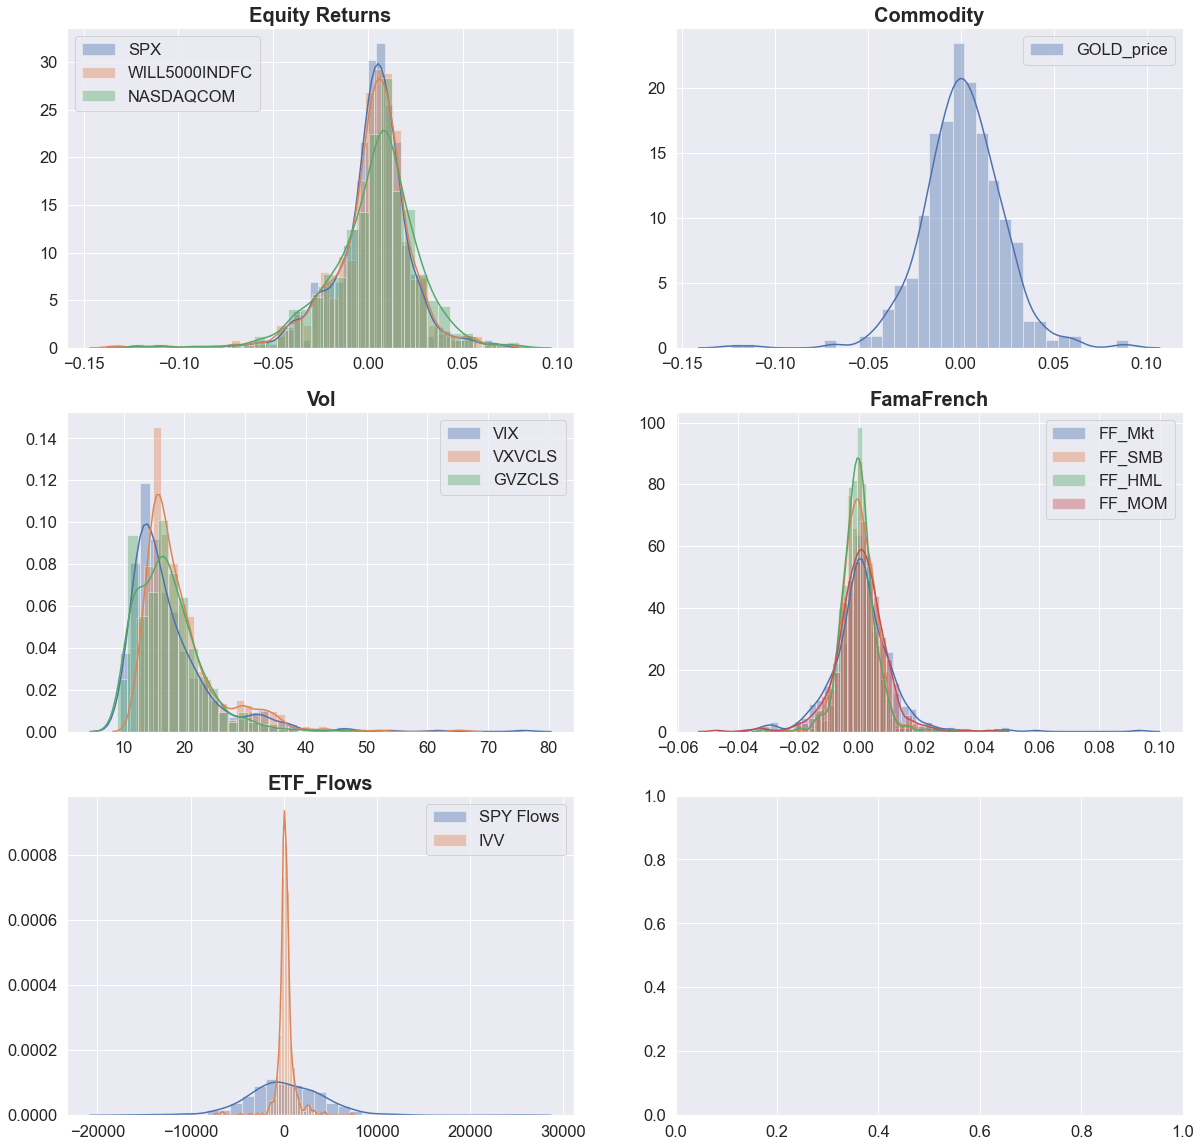

In [13]:
#look at one of each Asset Type Across Time
fig = plt.figure(figsize = (20,20))
sns.set(font_scale = 1.5)
axs = fig.subplots(3,2)
keys_cur = key_list[10:15]
for j in range(len(keys_cur)):    
    item_names = Asset[keys_cur[j]]
    for i in range(len(item_names)):
        axs[j//2, j%2].set_ylabel("Distribution", fontsize = 15)
        axs[j//2, j%2].set_ylabel("", fontsize = 15)
        axs[j//2, j%2].set_title(keys_cur[j], fontsize = 20,fontweight="bold")
        if(item_names[i][-2:]=="_S"):
            x = pd.Series(-df.loc[:,item_names[i]], name = "")
        else:
            x = pd.Series(df.loc[:,item_names[i]], name = "")
        sns.distplot(x, label = item_names[i],ax=axs[j//2,j%2])
    axs[j//2, j%2].legend()

In [14]:
#Lag contemporaneous CoT Data Elements
lag = ['Lev_NetPos','AM_n_L','AM_n_S','Lev_n_L','Lev_n_S','AM_L','AM_S','Lev_L','Lev_S']
new_name = ['lag_'+s for s in lag]
train[new_name]=train[lag].shift(1)
train=train.drop(labels  = lag, axis = 1)
test[new_name]=test[lag].shift(1)
test=test.drop(labels = lag, axis = 1)
train = train.dropna(axis = 0)
test = test.dropna(axis = 0)

In [15]:
#Split Predictors and Response (assumes time is col 0)
X_train = train.iloc[:,1:]
y_train = train.iloc[:,0]
X_test = test.iloc[:,1:]
y_test = test.iloc[:,0]

In [16]:
train['year'] = train.index.year

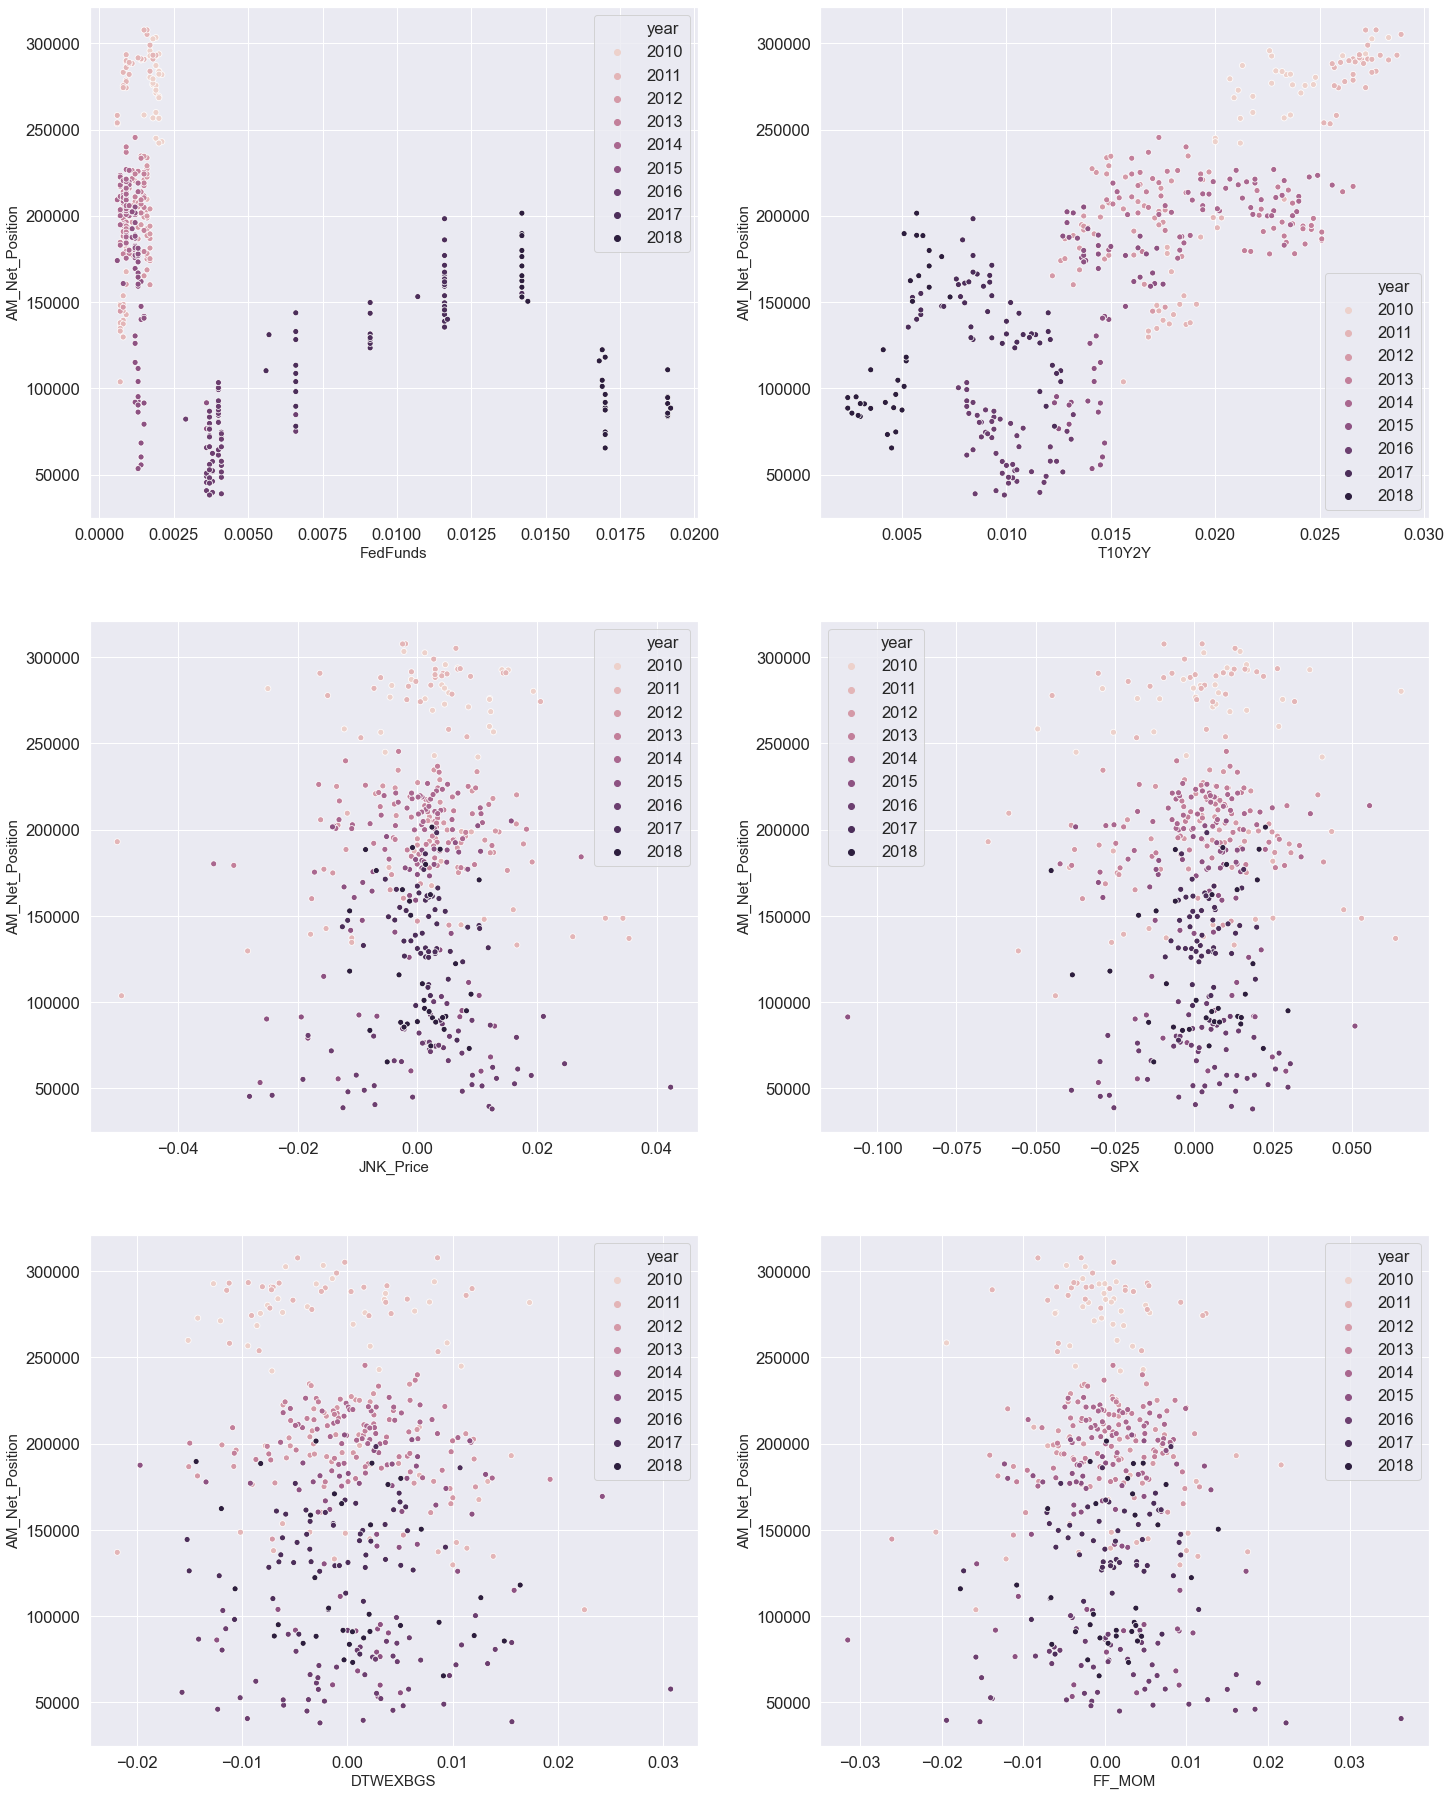

In [17]:
#look at one of each Asset Type Across Time
fig = plt.figure(figsize = (24,32))
sns.set(font_scale = 1.5)
axs = fig.subplots(3,2)
picklst = ['FedFunds', 'T10Y2Y', 'JNK_Price', 'SPX','DTWEXBGS','FF_MOM','SPY Flows','VIX']
for i in range(6):
    sns.scatterplot(x=train.loc[:,picklst[i]], y=y_train, data=train, hue="year",legend="full", ax=axs[i//2,i%2])
    axs[i//2, i%2].set_ylabel("AM_Net_Position", fontsize = 15)
    axs[i//2, i%2].set_xlabel(picklst[i], fontsize = 15)

Text(0.5, 0, 'lag_AM_NetPos')

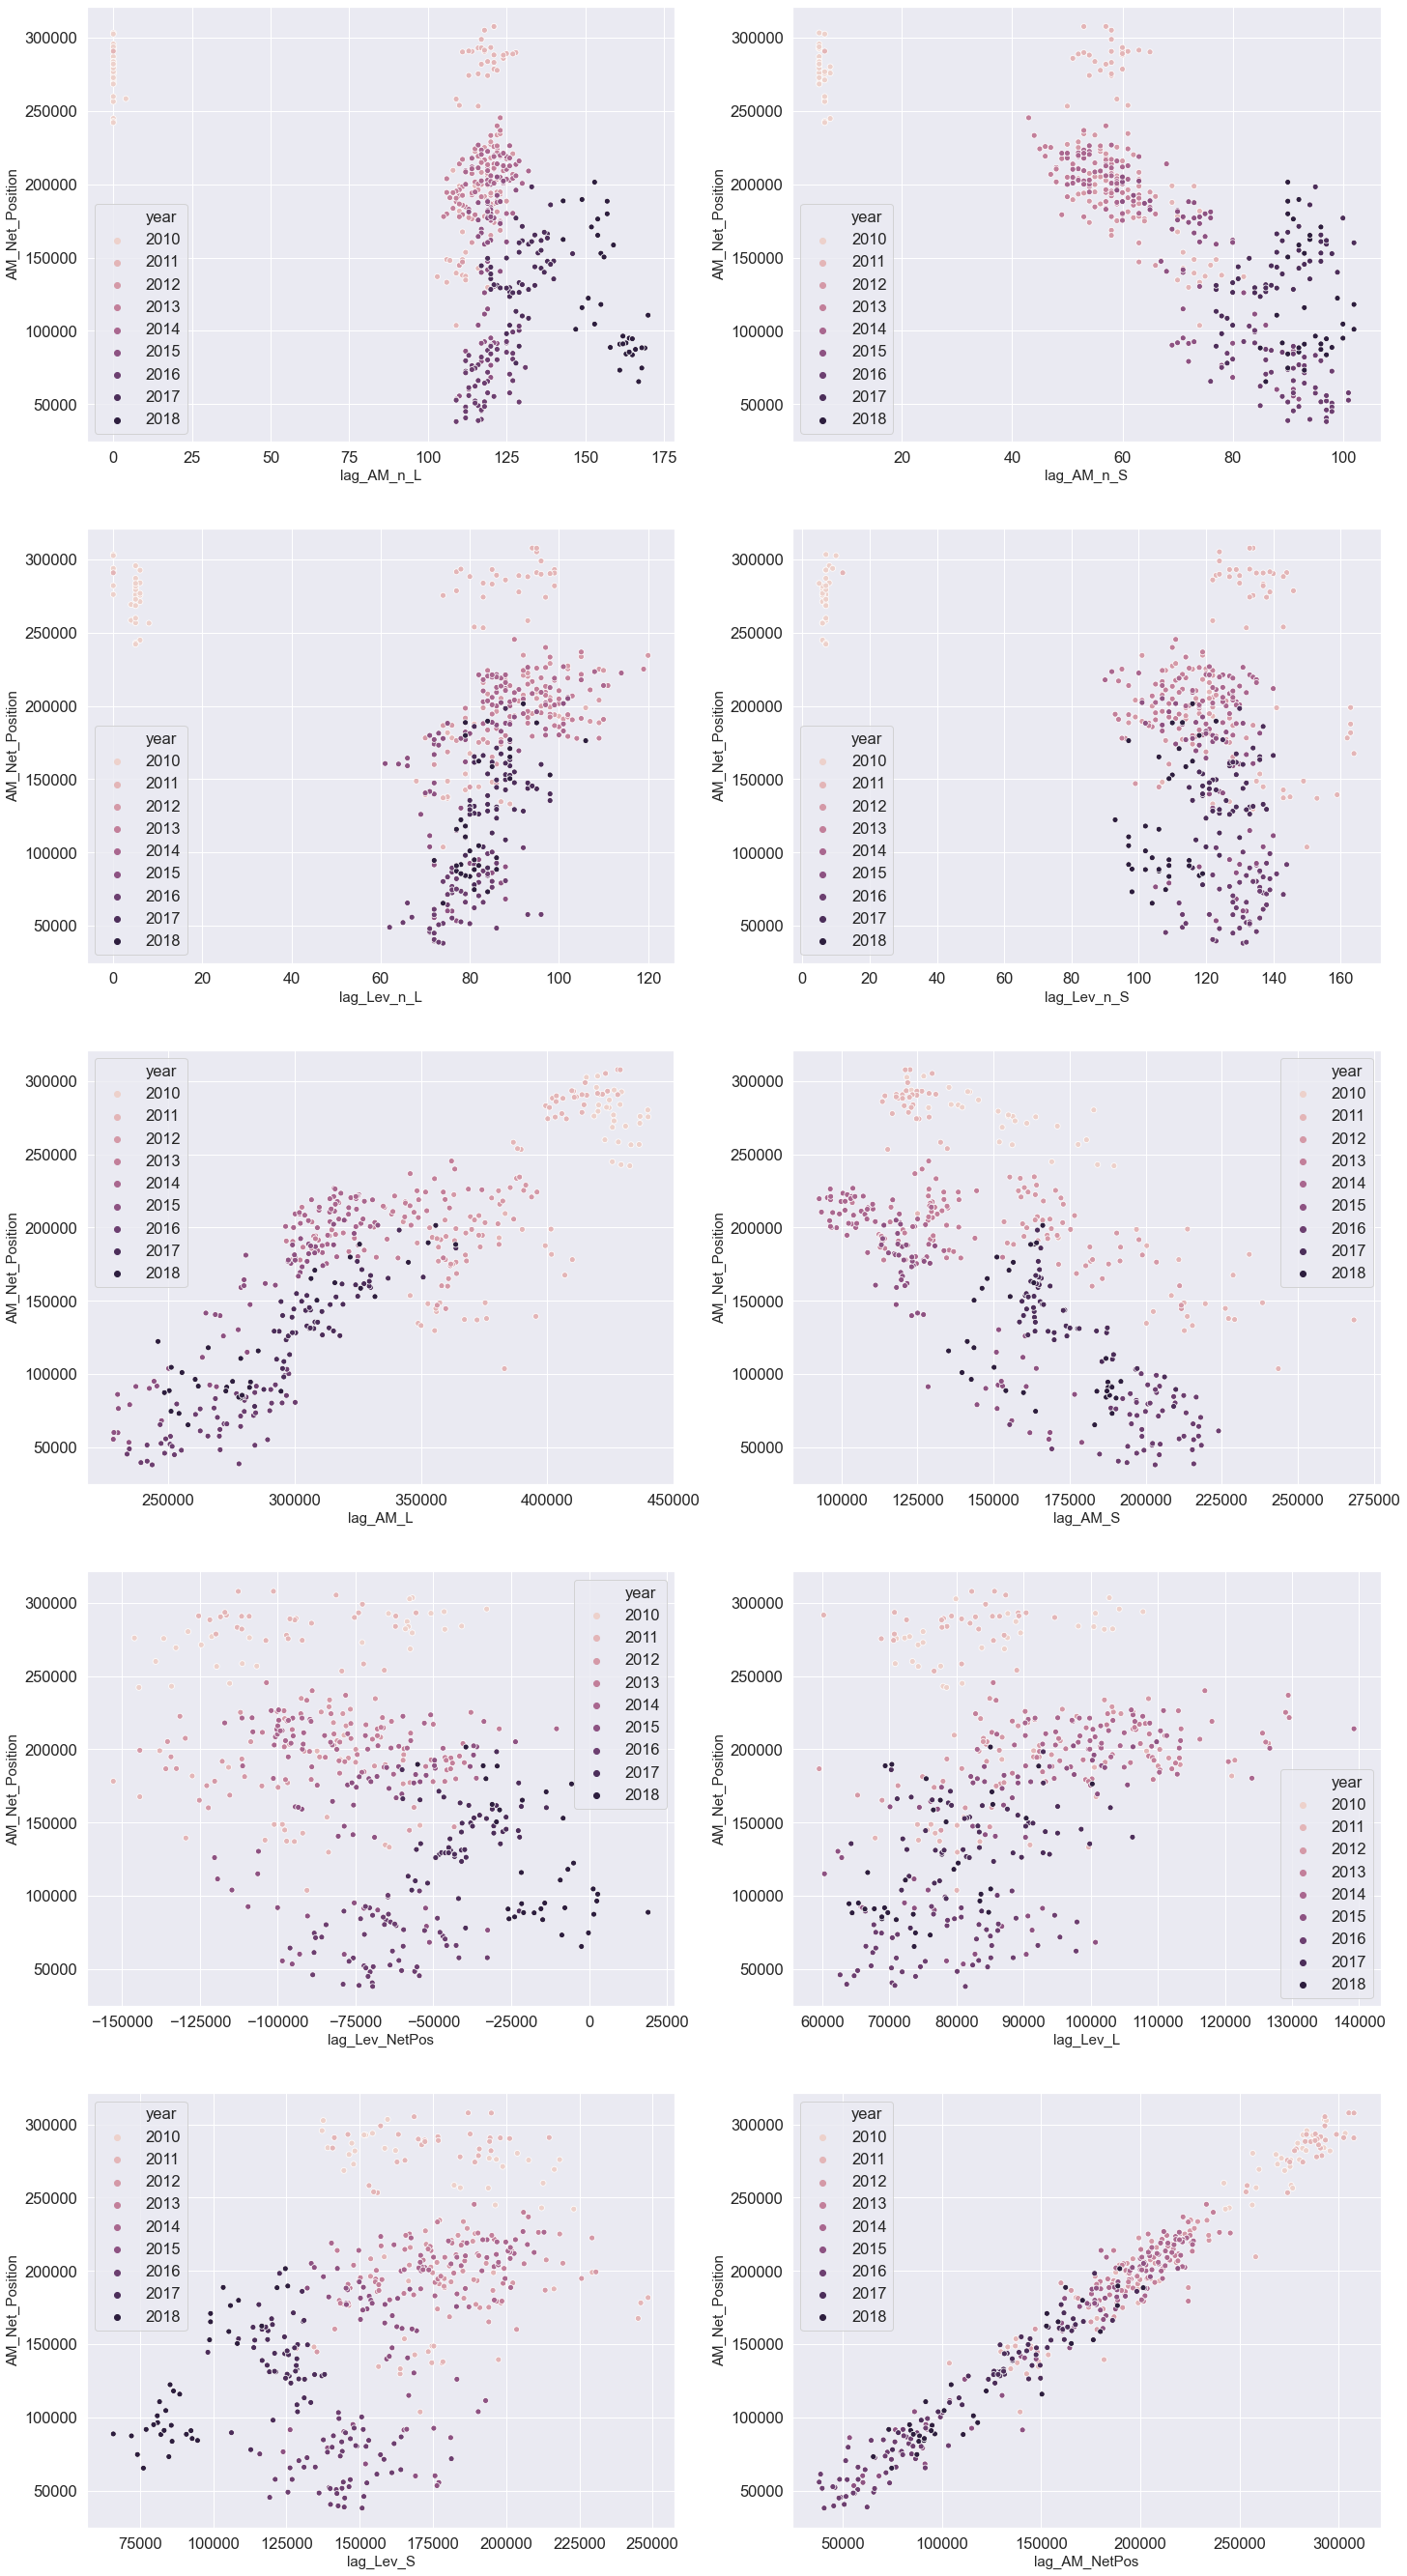

In [18]:
fig = plt.figure(figsize = (24,48))
sns.set(font_scale = 1.5)
axs = fig.subplots(5,2)
picklst = ['lag_AM_n_L', 'lag_AM_n_S', 'lag_Lev_n_L', 'lag_Lev_n_S', 'lag_AM_L', 'lag_AM_S',\
           'lag_Lev_NetPos', 'lag_Lev_L','lag_Lev_S']
for i in range(9):
    sns.scatterplot(x=train.loc[:,picklst[i]], y=y_train, data=train, hue="year",legend="full", ax=axs[i//2,i%2])
    axs[i//2, i%2].set_ylabel("AM_Net_Position", fontsize = 15)
    axs[i//2, i%2].set_xlabel(picklst[i], fontsize = 15)

sns.scatterplot(x = y_train.shift(1), y = y_train, data = train, hue = "year", legend = "full", ax = axs[4,1])
axs[4,1].set_ylabel("AM_Net_Position", fontsize = 15)
axs[4,1].set_xlabel("lag_AM_NetPos", fontsize = 15)

__Standardization__

In [19]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

In [20]:
def tsplot(y, lags = None, figsize = (10,8), style = 'bmh', title = 'Return Time Series'):
        if not isinstance(y,pd.Series):
            y = pd.Series(y)
        with plt.style.context(style):
            fig = plt.figure(figsize = figsize)
            layout = (2,2)
            ts_ax = plt.subplot2grid(layout, (0,0),colspan = 2)
            acf_ax = plt.subplot2grid(layout, (1,1))
            qq_ax = plt.subplot2grid(layout,(1,0))
            y.plot(ax = ts_ax)
            ts_ax.set_title(title)
            smt.graphics.plot_acf(y,lags = lags, ax = acf_ax, alpha = .05)
            sm.qqplot(y,line = 's',ax = qq_ax)
            qq_ax.set_title('QQ Plot')
            plt.tight_layout()
        return

In [21]:
benchmark_res = pd.DataFrame(index = ['Ridge', 'Lasso', 'RF'], columns = ['MSE', 'MAE'])

__Ridge__

In [22]:
ridge = RidgeCV(alphas = np.linspace(0.1,1,100))
ridge.fit(X_train_std, y_train)
print("CV alpha: ",ridge.alpha_)

benchmark_res.loc['Ridge', 'MSE'] = mean_squared_error(y_test, ridge.predict(X_test_std))
benchmark_res.loc['Ridge', 'MAE'] =  mean_absolute_error(y_test, ridge.predict(X_test_std))

CV alpha:  0.1


MAE on training set: 6033.01
MAE on testing set: 14934.77


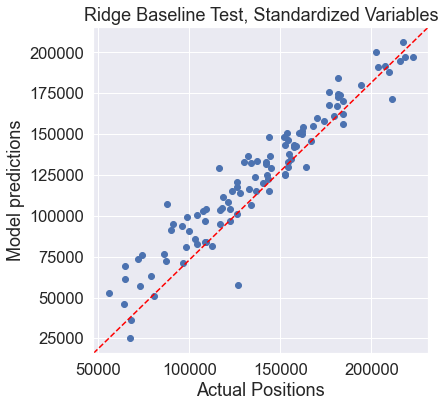

In [23]:
y_pred = ridge.predict(X_train_std)
mae = mean_absolute_error(y_train, y_pred)
string_score = f'MAE on training set: {mae:.2f}'
y_pred = ridge.predict(X_test_std)
mae = mean_absolute_error(y_test, y_pred)
string_score += f'\nMAE on testing set: {mae:.2f}'

fig, ax = plt.subplots(figsize=(6, 6))
plt.scatter(y_test, y_pred)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c="red")

plt.title('Ridge Baseline Test, Standardized Variables')
plt.ylabel('Model predictions')
plt.xlabel('Actual Positions')
print(string_score)

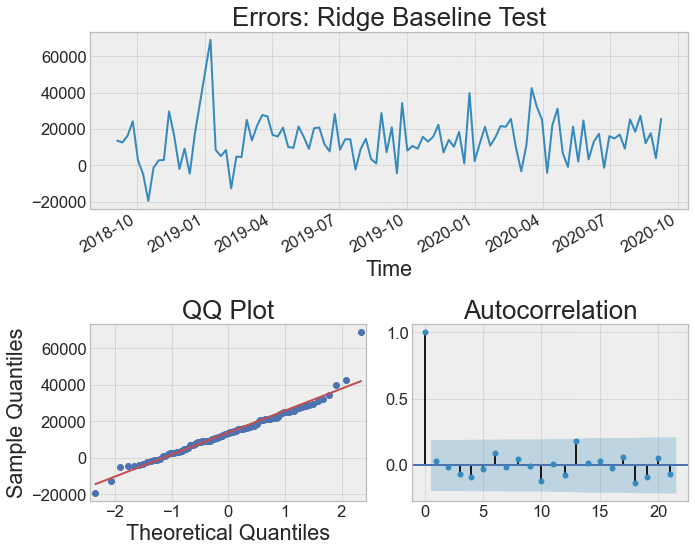

In [24]:
tsplot(y_test-y_pred,title = "Errors: Ridge Baseline Test")

(-0.05244627058970836,
 1.3213716823838757,
 -57965.68919299757,
 55702.851820079246)

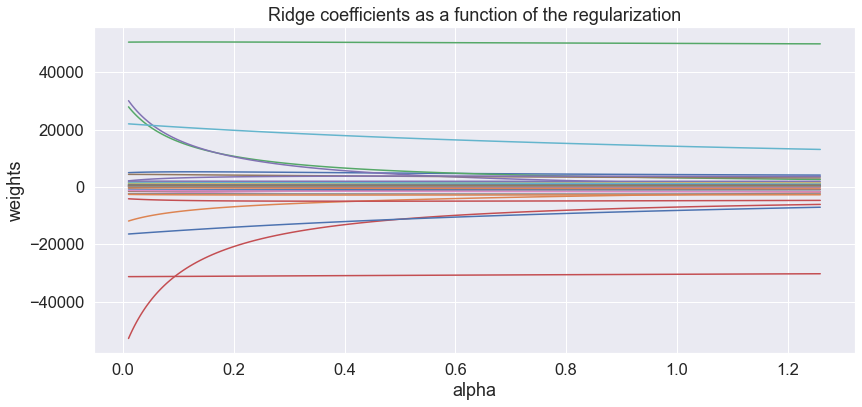

In [25]:
clf = Ridge()

coefs = []
errors = []

alphas = np.logspace(-2,.1,100)

# Train the model with different regularisation strengths
for a in alphas:
    clf.set_params(alpha=a)
    clf.fit(X_train_std, y_train)
    coefs.append(clf.coef_)
    

plt.figure(figsize=(30, 6))

plt.subplot(121)
ax = plt.gca()
ax.plot(alphas, coefs)
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')


__Lasso__

In [26]:
lasso = LassoCV(max_iter = 10000, alphas = np.logspace(.1,3,100))
lasso.fit(X_train_std, y_train)

LassoCV(alphas=array([   1.25892541,    1.34676844,    1.44074081,    1.54127022,
          1.64881419,    1.76386217,    1.88693776,    2.0186011 ,
          2.1594514 ,    2.3101297 ,    2.47132176,    2.64376119,
          2.82823278,    3.0255761 ,    3.23668929,    3.46253315,
          3.70413553,    3.96259601,    4.23909088,    4.53487851,
          4.85130507,    5.18981068,    5.55193591,    5.93932887,
          6.35375264,    6.79709332,    7.27136862,    7.77873705,
          8.32150772,    8.90215085,    9....
        161.84187792,  173.13458823,  185.21526088,  198.1388769 ,
        211.96425366,  226.75431259,  242.57636554,  259.50242114,
        277.60951248,  296.98004774,  317.70218523,  339.87023462,
        363.58508612,  388.9546697 ,  416.09444628,  445.12793318,
        476.1872663 ,  509.41380148,  544.95875783,  582.98390597,
        623.66230422,  667.17908629,  713.7323038 ,  763.53382765,
        816.81031231,  873.8042273 ,  934.77496078, 1000.        ]),

In [27]:
print(np.log(lasso.alpha_))
benchmark_res.loc['Lasso', 'MSE'] = mean_squared_error(y_test, lasso.predict(X_test_std))
benchmark_res.loc['Lasso', 'MAE'] =  mean_absolute_error(y_test, lasso.predict(X_test_std))

5.288968183301474


MAE on training set: 6247.90
MAE on testing set: 17694.90


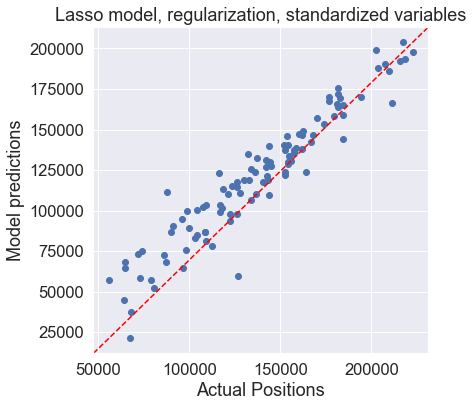

In [28]:
y_pred = lasso.predict(X_train_std)
mae = mean_absolute_error(y_train, y_pred)
string_score = f'MAE on training set: {mae:.2f}'
y_pred = lasso.predict(X_test_std)
mae = mean_absolute_error(y_test, y_pred)
string_score += f'\nMAE on testing set: {mae:.2f}'

fig, ax = plt.subplots(figsize=(6, 6))
plt.scatter(y_test, y_pred)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c="red")

plt.title('Lasso model, regularization, standardized variables')
plt.ylabel('Model predictions')
plt.xlabel('Actual Positions')
print(string_score)

In [29]:
print("Lasso Variable Selection:")
vars = list(X_train.columns[np.abs(lasso.coef_ - 0) > 1e-4])
vars

Lasso Variable Selection:


['T10Y3M',
 'T10YIE',
 'SPX',
 'GOLD_price',
 'VIX',
 'GVZCLS',
 'JPY',
 'EUR',
 'FF_Mkt',
 'FF_SMB',
 'FF_MOM',
 'SPY Flows',
 'JNK_Volume',
 'lag_Lev_n_S',
 'lag_AM_L',
 'lag_AM_S',
 'lag_Lev_L']

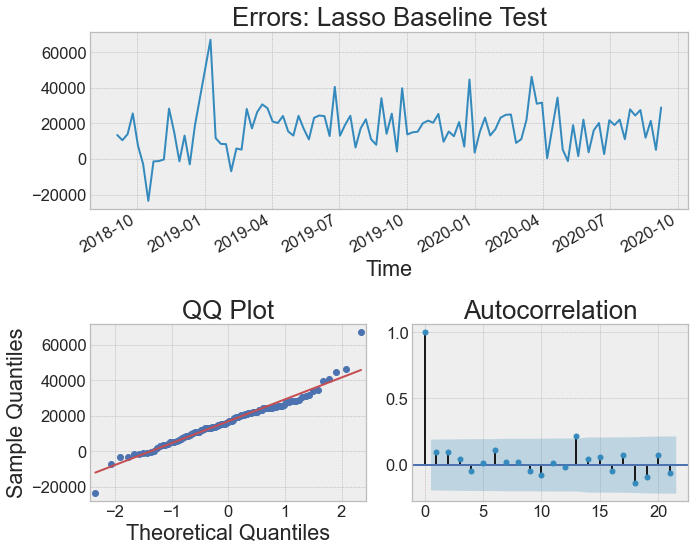

In [30]:
tsplot(y_test-y_pred,title = "Errors: Lasso Baseline Test")

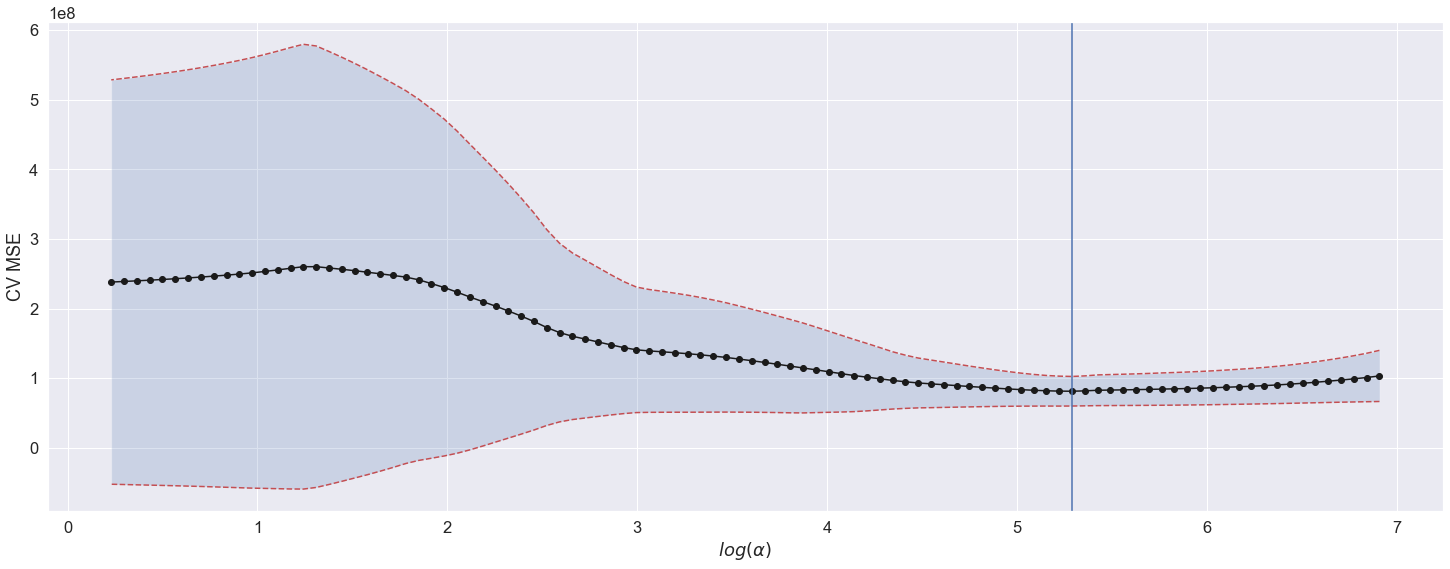

In [31]:
alpha_range = lasso.alphas_
mse_values = lasso.mse_path_.mean(axis = 1)
sd_values = lasso.mse_path_.std(axis = 1)
plt.figure(figsize=(25, 9))

plt.plot(np.log(alpha_range), mse_values ,"ko-")
plt.plot(np.log(alpha_range), mse_values + sd_values,"r--")
plt.plot(np.log(alpha_range), mse_values - sd_values,"r--")
plt.fill_between(np.log(alpha_range),
                mse_values + sd_values,
                mse_values - sd_values, alpha = .2)
plt.axvline(np.log(lasso.alpha_))
plt.xlabel(r"$log(\alpha)$")
plt.ylabel("CV MSE");

__Random Forest__

In [32]:
rf = RandomForestRegressor(n_estimators = 20)
rf.fit(X_train_std, y_train)

benchmark_res.loc['RF', 'MSE'] = mean_squared_error(y_test, rf.predict(X_test_std))
benchmark_res.loc['RF', 'MAE'] = mean_absolute_error(y_test, rf.predict(X_test_std))

y_pred = rf.predict(X_train_std)
mae = mean_absolute_error(y_train, y_pred)
string_score = f'MAE on training set: {mae:.2f}'
y_pred = rf.predict(X_test_std)
mae = mean_absolute_error(y_test, y_pred)
string_score += f'\nMAE on testing set: {mae:.2f}'
print(string_score)

MAE on training set: 3922.75
MAE on testing set: 28536.55


MAE on training set: 3922.75
MAE on testing set: 28536.55


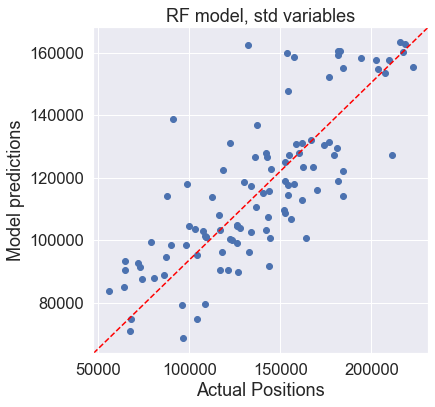

In [33]:
fig, ax = plt.subplots(figsize=(6, 6))
plt.scatter(y_test, y_pred)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c="red")

plt.title('RF model, std variables')
plt.ylabel('Model predictions')
plt.xlabel('Actual Positions')
print(string_score)

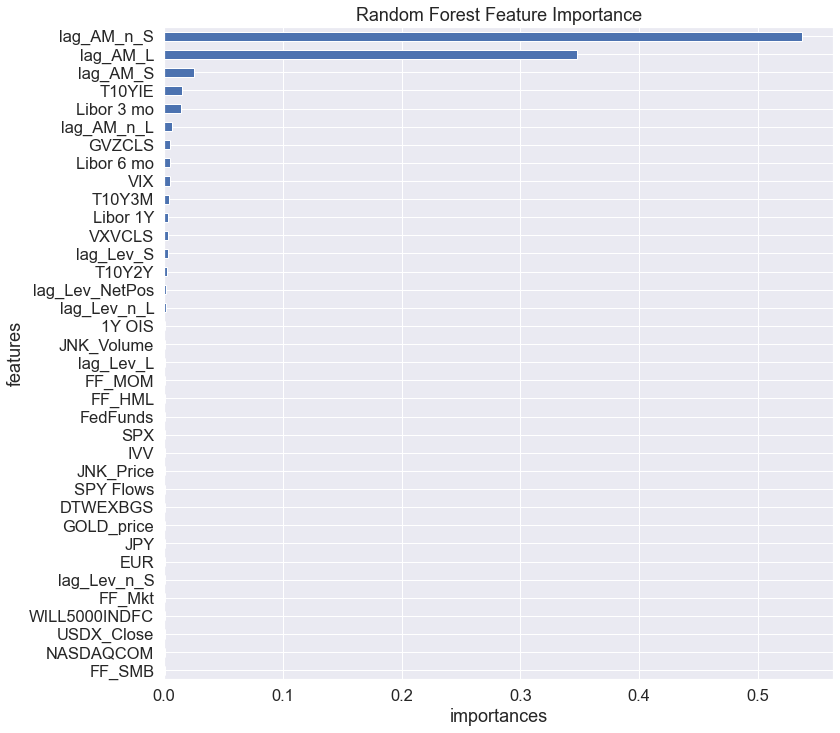

In [34]:

feat_importance = pd.Series(rf.feature_importances_, index = X_train.columns)
fis = np.argsort(feat_importance)
feat_importance = feat_importance[fis]
fig = plt.figure(figsize = [12,12])
ax = fig.subplots(1,1)
feat_importance.plot(kind = 'barh', ax = ax)
plt.ylabel('features')
plt.xlabel('importances')
plt.title("Random Forest Feature Importance")
plt.show()

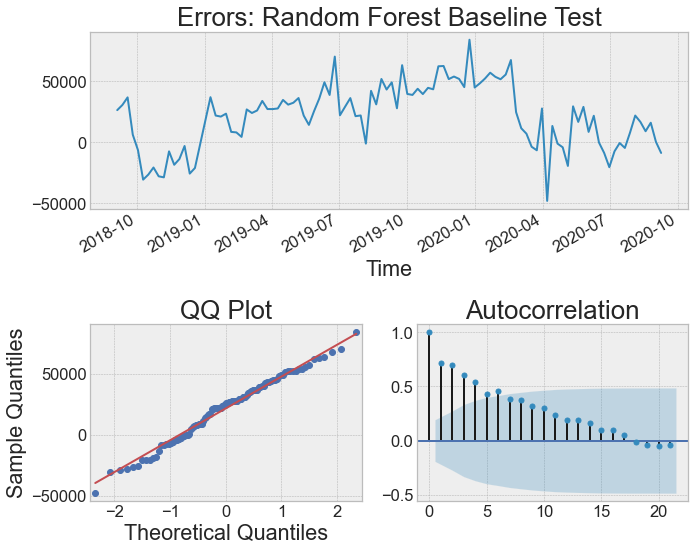

In [35]:
y_pred = rf.predict(X_test_std)
tsplot(y_test-y_pred,title = "Errors: Random Forest Baseline Test")

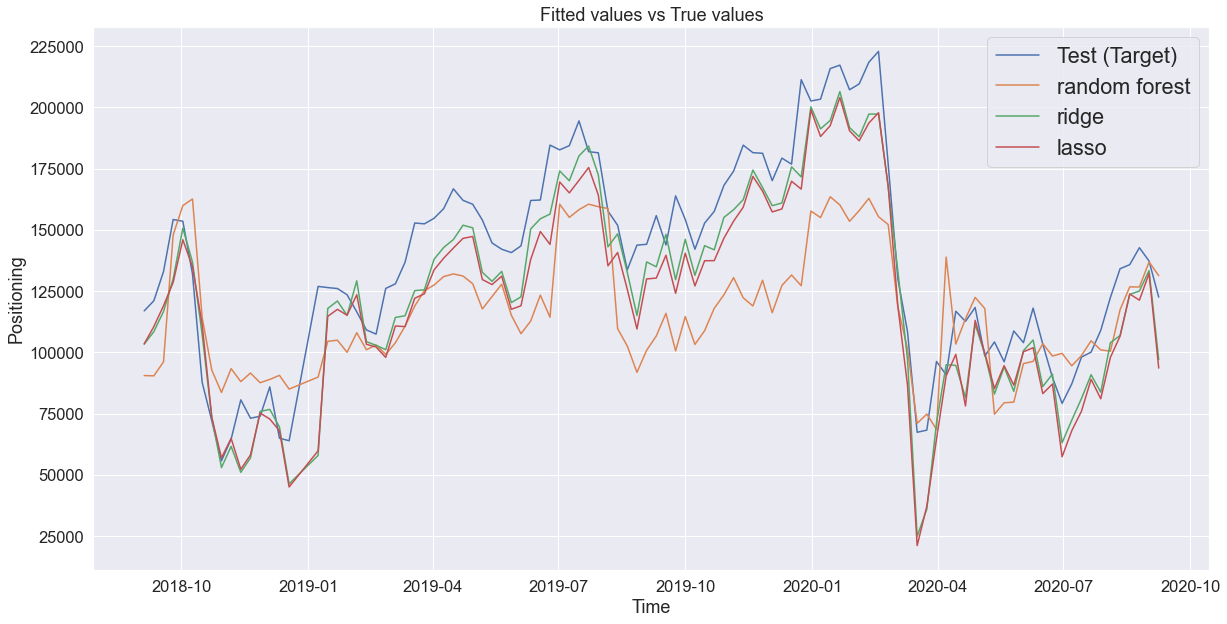

In [36]:
fig = plt.figure(figsize = [20,10])
plt.plot(test.index, y_test, label = 'Test (Target)')
plt.plot(test.index, rf.predict(X_test_std), label = 'random forest')
plt.plot(test.index, ridge.predict(X_test_std), label = 'ridge')
plt.plot(test.index, lasso.predict(X_test_std), label = 'lasso')
plt.xlabel("Time")
plt.ylabel("Positioning")
plt.title('Fitted values vs True values')
plt.legend(fontsize = 'large')

In [37]:
benchmark_res

MSE      MAE
Ridge  3.34963e+08  14934.8
Lasso  4.36692e+08  17694.9
RF     1.14441e+09  28536.5

__Predict Change in AM Position__

In [38]:
#reimporting, so we do difference and lag at same time
train=pd.read_csv('train_weekly.csv',index_col = "Time",parse_dates=True )
test = pd.read_csv('test_weekly.csv',index_col = "Time",parse_dates=True)
benchmark_res = pd.DataFrame(index = ['Ridge', 'Lasso', 'RF'], columns = ['MSE', 'MAE'])

In [39]:
train['d_AM_NetPos'] = train['AM_NetPos'].diff()
test['d_AM_NetPos'] = test['AM_NetPos'].diff()
train.iloc[0,len(train.columns)-1]=0
test.iloc[0,len(test.columns)-1]=0


In [40]:
cols = ['AM_NetPos','Unnamed: 0','Signal','Flag']  #cols to drop
train = train.drop(columns = cols)
test = test.drop(columns = cols)
lag = ['Lev_NetPos','AM_n_L','AM_n_S','Lev_n_L','Lev_n_S','AM_L','AM_S','Lev_L','Lev_S']
new_name = ['lag_'+s for s in lag]
train[new_name]=train[lag].shift(1)
train=train.drop(labels  = lag, axis = 1)
test[new_name]=test[lag].shift(1)
test=test.drop(labels = lag, axis = 1)
train = train.dropna(axis = 0)
test = test.dropna(axis = 0)



In [41]:
#pop modifies original data frame
y_train = train.pop('d_AM_NetPos')
y_test = test.pop('d_AM_NetPos')

In [42]:
X_train = train
X_test = test
train['year'] = train.index.year

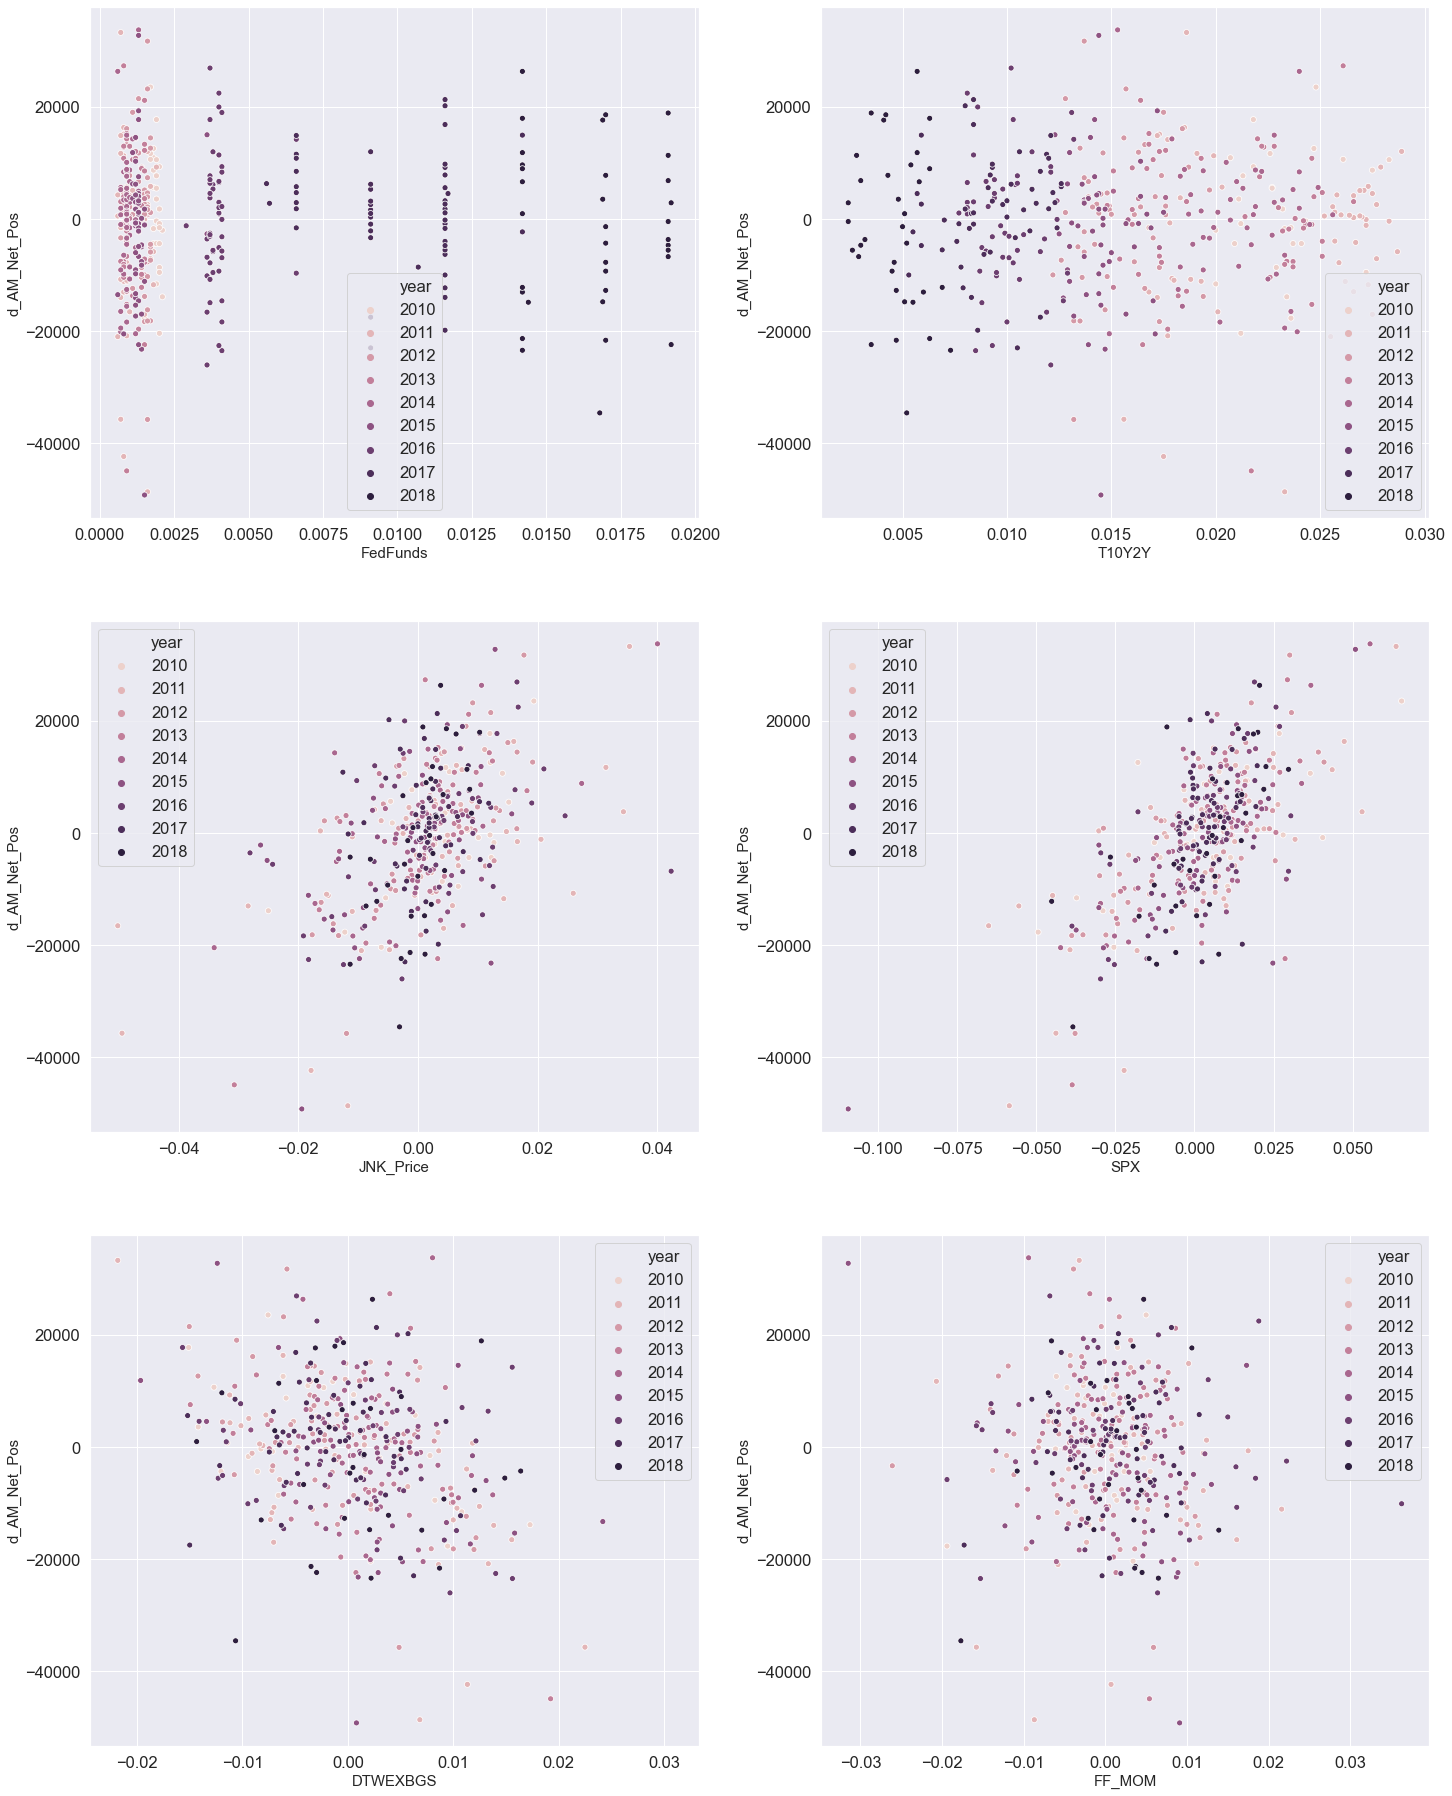

In [43]:
#look at one of each Asset Type Across Time
fig = plt.figure(figsize = (24,32))
sns.set(font_scale = 1.5)
axs = fig.subplots(3,2)
picklst = ['FedFunds', 'T10Y2Y', 'JNK_Price', 'SPX','DTWEXBGS','FF_MOM','SPY Flows','VIX']
for i in range(6):
    sns.scatterplot(x=train.loc[:,picklst[i]], y=y_train, data=train, hue="year",legend="full", ax=axs[i//2,i%2])
    axs[i//2, i%2].set_ylabel("d_AM_Net_Pos", fontsize = 15)
    axs[i//2, i%2].set_xlabel(picklst[i], fontsize = 15)

Text(0.5, 0, 'lag_AM_NetPos')

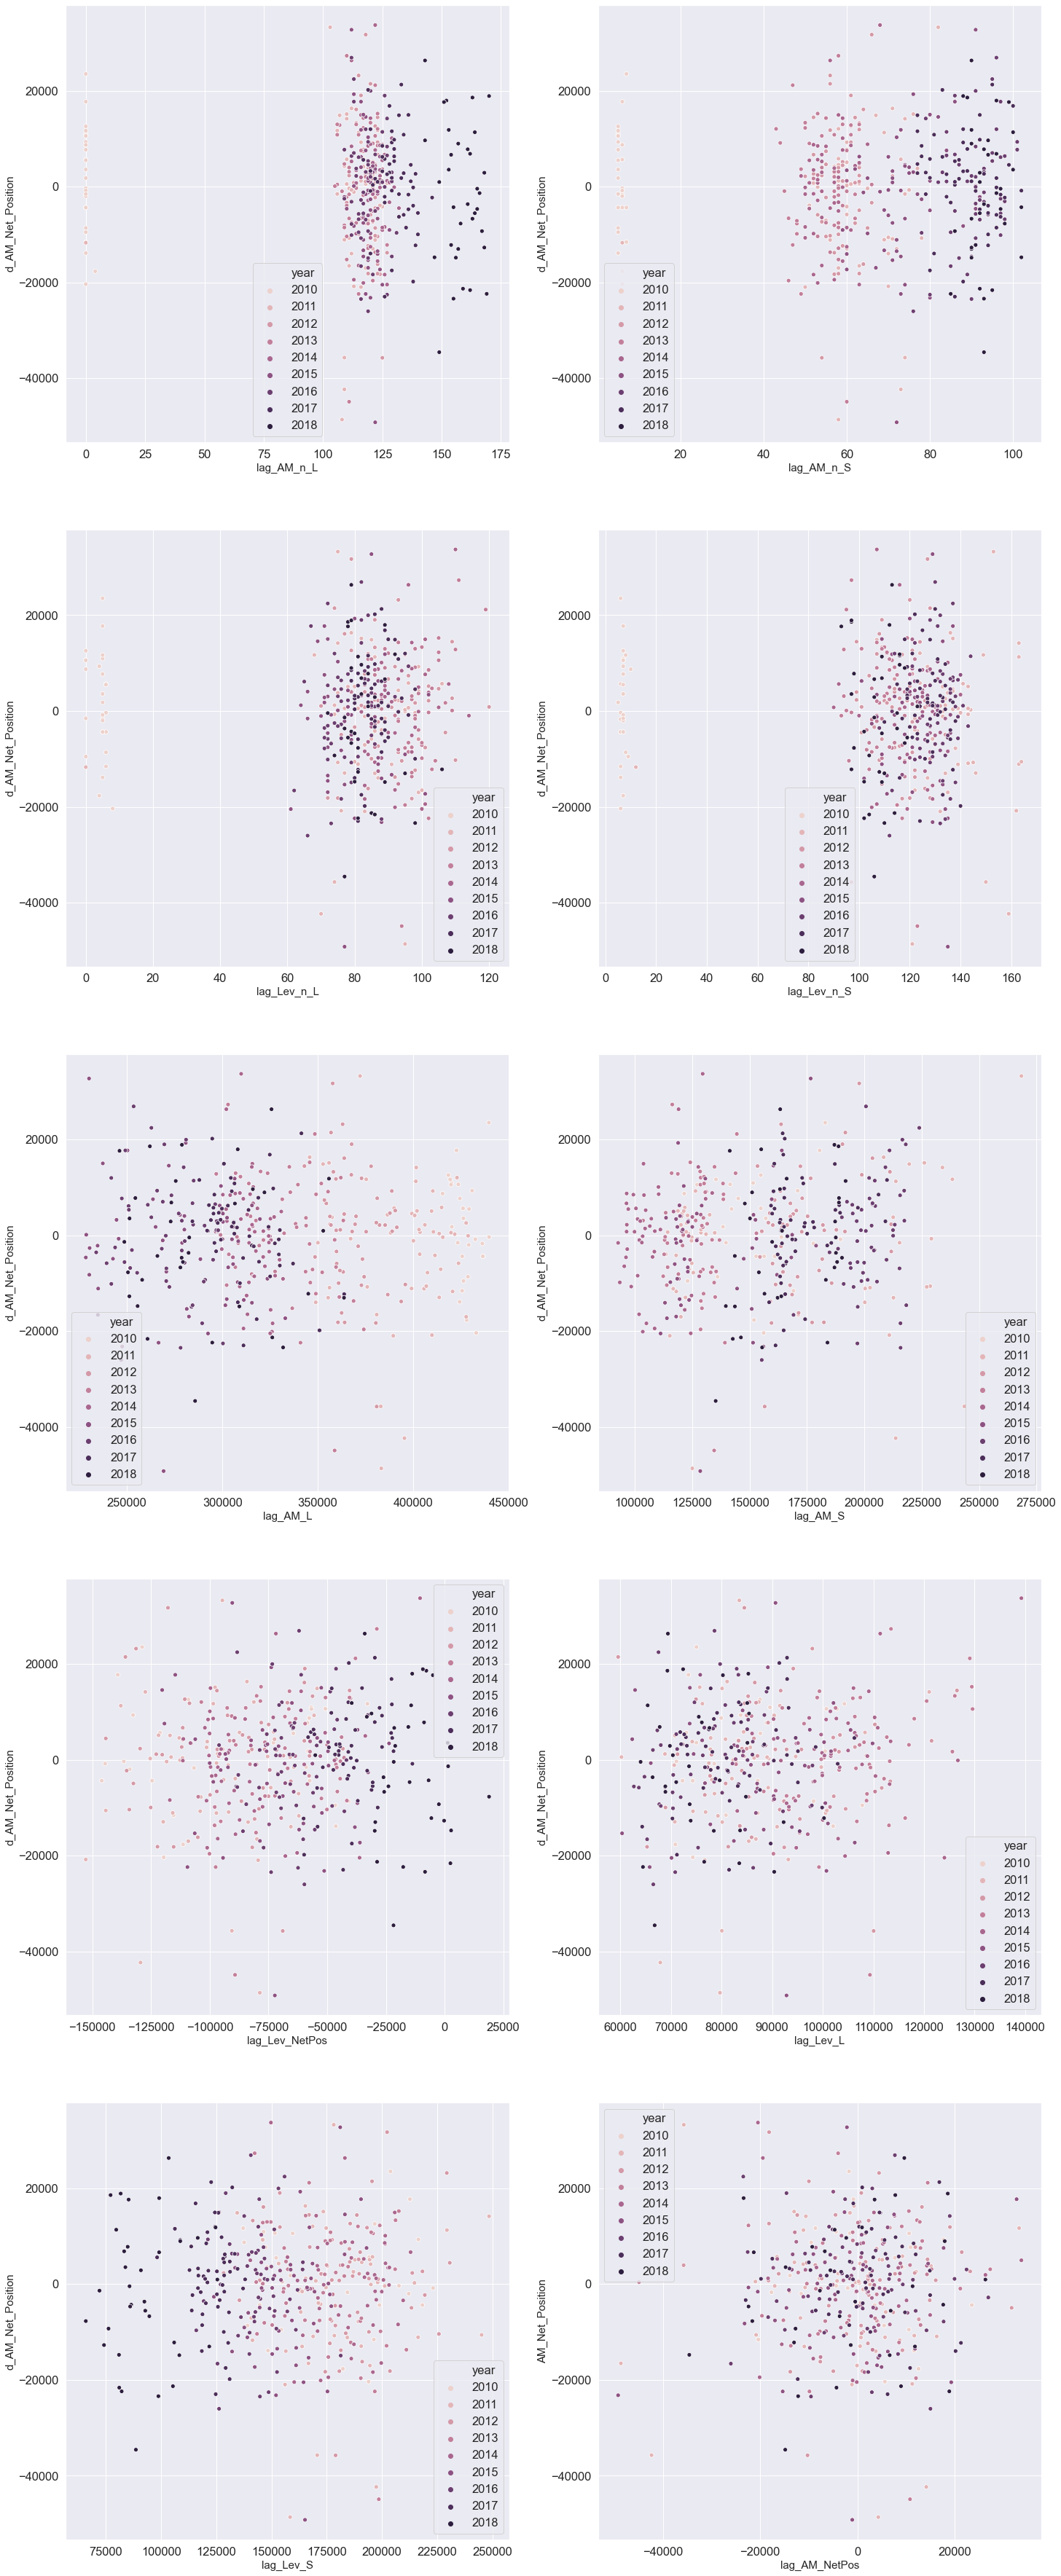

In [44]:
fig = plt.figure(figsize = (24,64))
sns.set(font_scale = 1.5)
axs = fig.subplots(5,2)
picklst = ['lag_AM_n_L', 'lag_AM_n_S', 'lag_Lev_n_L', 'lag_Lev_n_S', 'lag_AM_L', 'lag_AM_S',\
           'lag_Lev_NetPos', 'lag_Lev_L','lag_Lev_S']
for i in range(9):
    sns.scatterplot(x=train.loc[:,picklst[i]], y=y_train, data=train, hue="year",legend="full", ax=axs[i//2,i%2])
    axs[i//2, i%2].set_ylabel("d_AM_Net_Position", fontsize = 15)
    axs[i//2, i%2].set_xlabel(picklst[i], fontsize = 15)

sns.scatterplot(x = y_train.shift(1), y = y_train, data = train, hue = "year", legend = "full", ax = axs[4,1])
axs[4,1].set_ylabel("AM_Net_Position", fontsize = 15)
axs[4,1].set_xlabel("lag_AM_NetPos", fontsize = 15)

In [45]:

X_train = X_train.drop(columns = ['year'])


In [46]:
benchmark_res = pd.DataFrame(index = ['Ridge', 'Lasso', 'RF'], columns = ['MSE', 'MAE'])

In [47]:
from sklearn.preprocessing import StandardScaler
scaler2 = StandardScaler()
scaler2.fit(X_train)
X_train_std = scaler2.transform(X_train)
X_test_std = scaler2.transform(X_test)

In [48]:
ridge = RidgeCV(alphas = np.linspace(0.1,1,100))
ridge.fit(X_train_std, y_train)
print("CV alpha: ",ridge.alpha_)

benchmark_res.loc['Ridge', 'MSE'] = mean_squared_error(y_test, ridge.predict(X_test_std))
benchmark_res.loc['Ridge', 'MAE'] =  mean_absolute_error(y_test, ridge.predict(X_test_std))

CV alpha:  0.1


MAE on training set: 6034.50
MAE on testing set: 14836.48


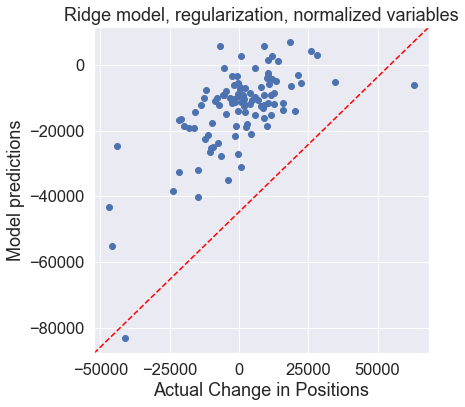

In [49]:
y_pred = ridge.predict(X_train_std)
mae = mean_absolute_error(y_train, y_pred)
string_score = f'MAE on training set: {mae:.2f}'
y_pred = ridge.predict(X_test_std)
mae = mean_absolute_error(y_test, y_pred)
string_score += f'\nMAE on testing set: {mae:.2f}'

fig, ax = plt.subplots(figsize=(6, 6))
plt.scatter(y_test, y_pred)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c="red")

plt.title('Ridge model, regularization, normalized variables')
plt.ylabel('Model predictions')
plt.xlabel('Actual Change in Positions')
print(string_score)

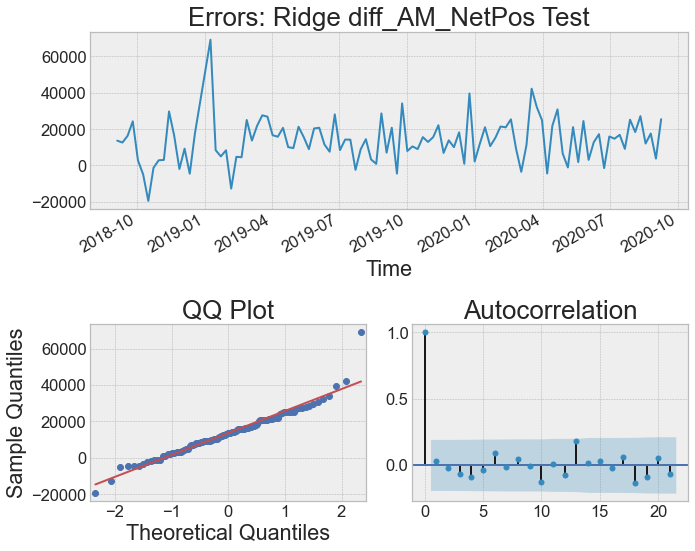

In [50]:
tsplot(y_test-y_pred,title = "Errors: Ridge diff_AM_NetPos Test")

(-0.05244627058970836,
 1.3213716823838757,
 -56918.30948448874,
 34210.483246023534)

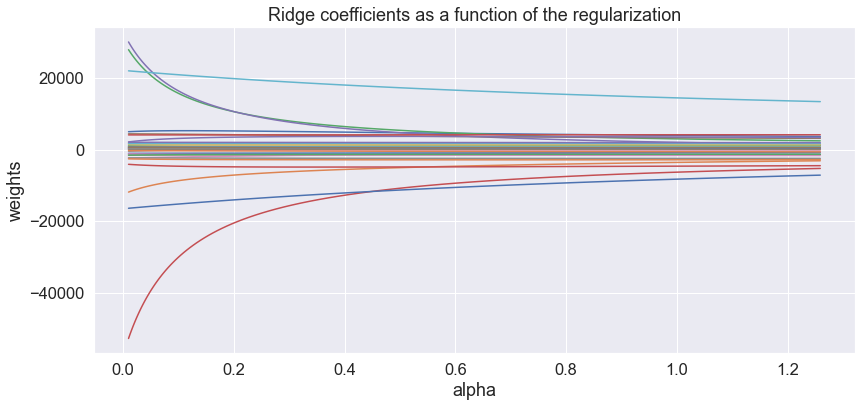

In [51]:
clf = Ridge()

coefs = []
errors = []

alphas = np.logspace(-2,.1,100)

# Train the model with different regularisation strengths
for a in alphas:
    clf.set_params(alpha=a)
    clf.fit(X_train_std, y_train)
    coefs.append(clf.coef_)
    

plt.figure(figsize=(30, 6))

plt.subplot(121)
ax = plt.gca()
ax.plot(alphas, coefs)
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')


In [52]:
lasso = LassoCV(max_iter = 10000, alphas = np.logspace(.1,3,100))
lasso.fit(X_train_std, y_train)

LassoCV(alphas=array([   1.25892541,    1.34676844,    1.44074081,    1.54127022,
          1.64881419,    1.76386217,    1.88693776,    2.0186011 ,
          2.1594514 ,    2.3101297 ,    2.47132176,    2.64376119,
          2.82823278,    3.0255761 ,    3.23668929,    3.46253315,
          3.70413553,    3.96259601,    4.23909088,    4.53487851,
          4.85130507,    5.18981068,    5.55193591,    5.93932887,
          6.35375264,    6.79709332,    7.27136862,    7.77873705,
          8.32150772,    8.90215085,    9....
        161.84187792,  173.13458823,  185.21526088,  198.1388769 ,
        211.96425366,  226.75431259,  242.57636554,  259.50242114,
        277.60951248,  296.98004774,  317.70218523,  339.87023462,
        363.58508612,  388.9546697 ,  416.09444628,  445.12793318,
        476.1872663 ,  509.41380148,  544.95875783,  582.98390597,
        623.66230422,  667.17908629,  713.7323038 ,  763.53382765,
        816.81031231,  873.8042273 ,  934.77496078, 1000.        ]),

In [53]:
print(np.log(lasso.alpha_))
benchmark_res.loc['Lasso', 'MSE'] = mean_squared_error(y_test, lasso.predict(X_test_std))
benchmark_res.loc['Lasso', 'MAE'] =  mean_absolute_error(y_test, lasso.predict(X_test_std))

5.626215494901613


In [54]:
print("Lasso Variable Selection:")
vars = list(X_train.columns[np.abs(lasso.coef_ - 0) > 1e-4])
vars

Lasso Variable Selection:


['T10Y3M',
 'SPX',
 'GOLD_price',
 'VIX',
 'GVZCLS',
 'JPY',
 'EUR',
 'FF_Mkt',
 'FF_SMB',
 'SPY Flows',
 'JNK_Volume',
 'lag_Lev_n_S',
 'lag_AM_L',
 'lag_AM_S',
 'lag_Lev_L']

MAE on training set: 6394.54
MAE on testing set: 11349.49


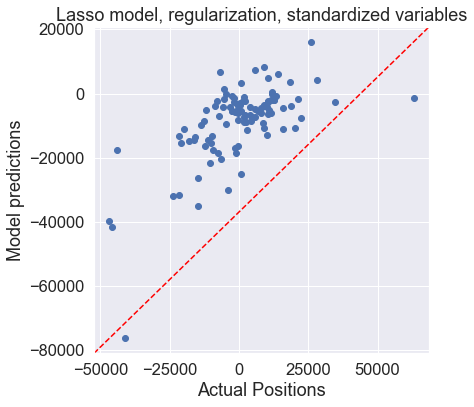

In [55]:
y_pred = lasso.predict(X_train_std)
mae = mean_absolute_error(y_train, y_pred)
string_score = f'MAE on training set: {mae:.2f}'
y_pred = lasso.predict(X_test_std)
mae = mean_absolute_error(y_test, y_pred)
string_score += f'\nMAE on testing set: {mae:.2f}'

fig, ax = plt.subplots(figsize=(6, 6))
plt.scatter(y_test, y_pred)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c="red")

plt.title('Lasso model, regularization, standardized variables')
plt.ylabel('Model predictions')
plt.xlabel('Actual Positions')
print(string_score)

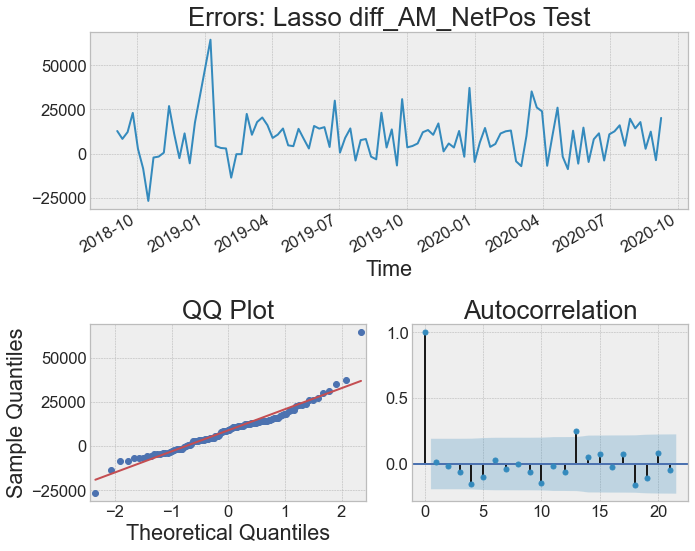

In [56]:
tsplot(y_test-y_pred,title = "Errors: Lasso diff_AM_NetPos Test")

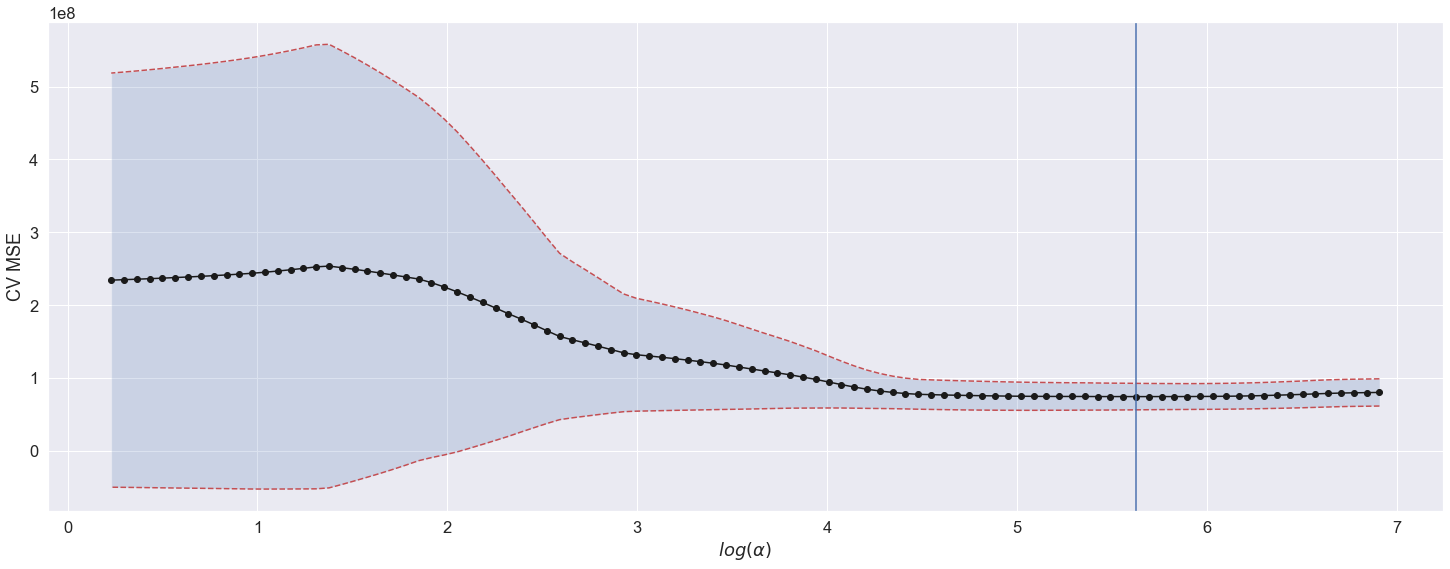

In [57]:
alpha_range = lasso.alphas_
mse_values = lasso.mse_path_.mean(axis = 1)
sd_values = lasso.mse_path_.std(axis = 1)
plt.figure(figsize=(25, 9))
plt.plot(np.log(alpha_range), mse_values ,"ko-")
plt.plot(np.log(alpha_range), mse_values + sd_values,"r--")
plt.plot(np.log(alpha_range), mse_values - sd_values,"r--")
plt.fill_between(np.log(alpha_range),
                mse_values + sd_values,
                mse_values - sd_values, alpha = .2)

plt.axvline(np.log(lasso.alpha_))
plt.xlabel(r"$log(\alpha)$")
plt.ylabel("CV MSE");

In [58]:
X_train.columns[np.abs(lasso.coef_ - 0) > 1e-4]

Index(['T10Y3M', 'SPX', 'GOLD_price', 'VIX', 'GVZCLS', 'JPY', 'EUR', 'FF_Mkt',
       'FF_SMB', 'SPY Flows', 'JNK_Volume', 'lag_Lev_n_S', 'lag_AM_L',
       'lag_AM_S', 'lag_Lev_L'],
      dtype='object')

In [59]:
rf = RandomForestRegressor(n_estimators = 20)
rf.fit(X_train_std, y_train)

benchmark_res.loc['RF', 'MSE'] = mean_squared_error(y_test, rf.predict(X_test_std))
benchmark_res.loc['RF', 'MAE'] = mean_absolute_error(y_test, rf.predict(X_test_std))

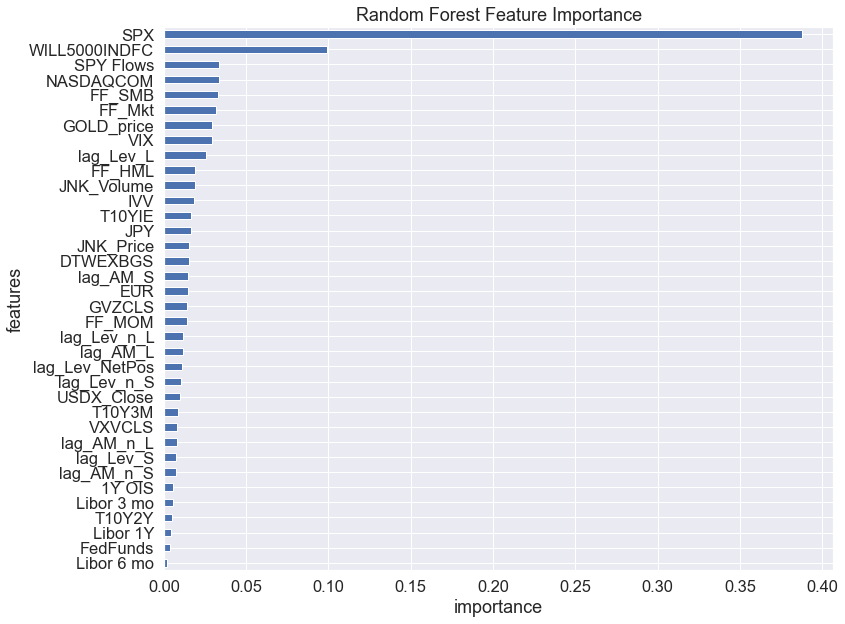

In [60]:
feat_importance = pd.Series(rf.feature_importances_, index = X_train.columns)
fis = np.argsort(feat_importance)
feat_importance = feat_importance[fis]
fig = plt.figure(figsize = [12,10])
ax = fig.subplots(1,1)
feat_importance.plot(kind = 'barh', ax = ax)
plt.ylabel('features')
plt.xlabel('importance')
plt.title("Random Forest Feature Importance")
plt.show()

MAE on training set: 6394.54
MAE on testing set: 11349.49


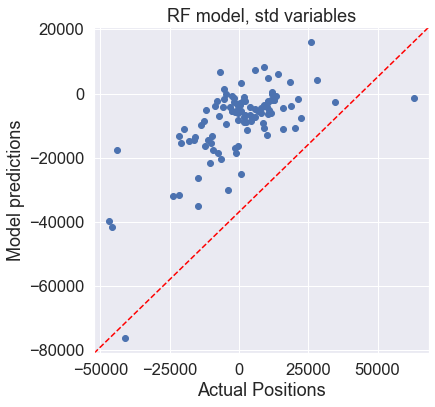

In [61]:
fig, ax = plt.subplots(figsize=(6, 6))
plt.scatter(y_test, y_pred)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c="red")

plt.title('RF model, std variables')
plt.ylabel('Model predictions')
plt.xlabel('Actual Positions')
print(string_score)

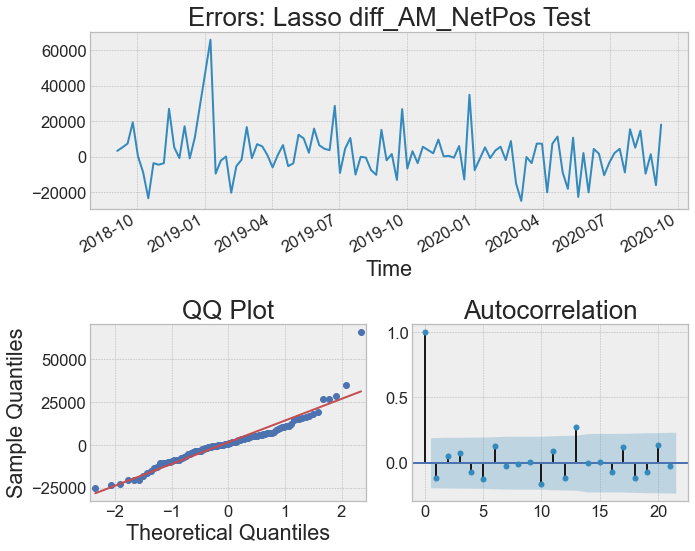

In [62]:
y_pred = rf.predict(X_test_std)
tsplot(y_test-y_pred,title = "Errors: Lasso diff_AM_NetPos Test")

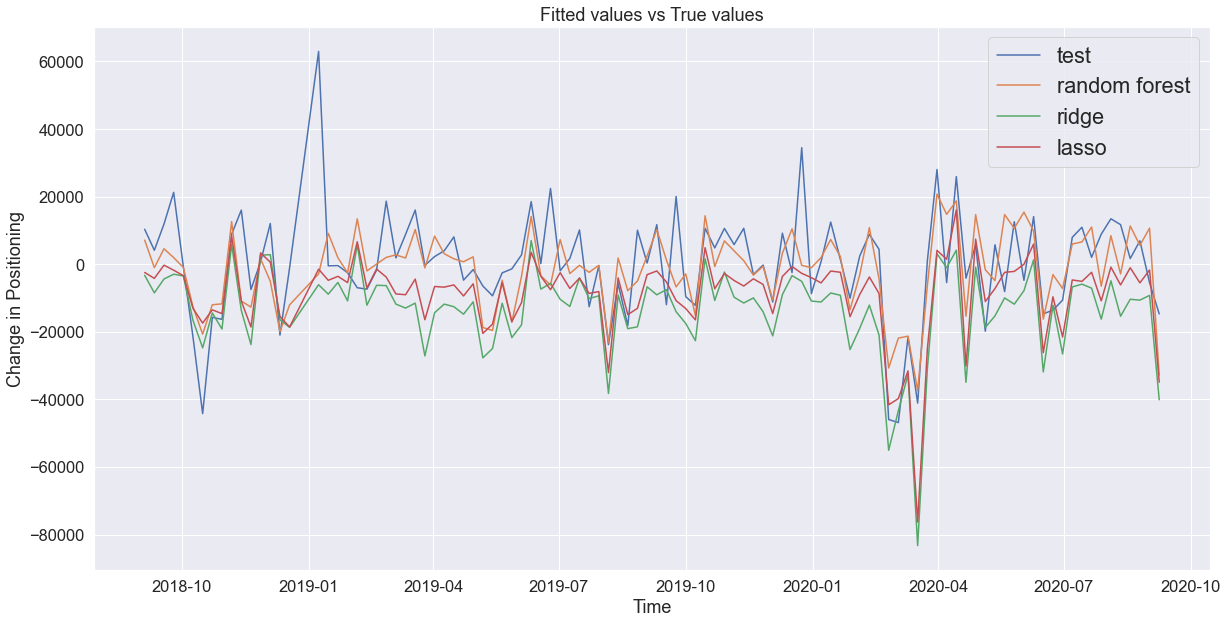

In [63]:
fig = plt.figure(figsize = [20,10])
plt.plot(test.index, y_test, label = 'test')
plt.plot(test.index, rf.predict(X_test_std), label = 'random forest')
plt.plot(test.index, ridge.predict(X_test_std), label = 'ridge')
plt.plot(test.index, lasso.predict(X_test_std), label = 'lasso')
plt.xlabel("Time")
plt.ylabel("Change in Positioning")
plt.title('Fitted values vs True values')
plt.legend(fontsize = 'large')

In [64]:
benchmark_res

MSE      MAE
Ridge  3.31538e+08  14836.5
Lasso  2.20323e+08  11349.5
RF     1.62817e+08  8795.13

In [75]:
fis = np.argsort(feat_importance)
feat_importance = feat_importance[fis]
print(feat_importance.sort_values(ascending = False)[0:10])

SPX              0.387507
WILL5000INDFC    0.099437
SPY Flows        0.033619
NASDAQCOM        0.033270
FF_SMB           0.032998
FF_Mkt           0.031678
GOLD_price       0.029385
VIX              0.029280
lag_Lev_L        0.025824
FF_HML           0.019003
dtype: float64
